In [1]:
import segmentation_models_pytorch as smp
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights, lraspp_mobilenet_v3_large, deeplabv3_resnet101

#Hyperparamters
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet' #pretrained weighting
#CLASSES = ["background", "skin", "nose", "right_eye", "left_eye", "right_brow", "left_brow", "right_ear", "left_ear", "mouth_interior", "top_lip", "bottom_lip", "neck", "hair", "beard", "clothing", "glasses", "headwear", "facewear"]
ACTIVATION = "sigmoid" # softmax2d for multiclass segmentation
num_classes = 12

"""
aux_params=dict(
    pooling='avg',       # one of 'avg', 'max'
    classes=num_classes, 
    activation = None
)
"""

#DEEPLABV3+

deeplab = smp.DeepLabV3Plus(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    #encoder_depth = 18,
    #decoder_channels = 18,
    #aux_params=aux_params
)


#UNET
unet = smp.Unet(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    #encoder_depth = 18,
    #decoder_channels = 18,
    decoder_use_batchnorm = True,
    #aux_params=aux_params
)

fcn = smp.FPN(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
)

mobile = smp.Unet(
    in_channels=3,
    encoder_name="mobilenet_v2", 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    decoder_use_batchnorm = True,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [2]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row (Original Image: Ground Truth : Predicted)
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        if name == "original_image":
          #print(image.shape)
          plt.title(name.replace('_',' ').title(), fontsize=20)
          plt.imshow(image)
        else:
          #print(image.shape)
          # get title from the parameter names
          plt.title(name.replace('_',' ').title(), fontsize=20)
          plt.imshow(image)
    plt.show()

#Function to reverse one-hot-encode an image
def reverse_one_hot(image):
    #argmax to return the indices of the maximum values along an axis. 
    x = np.argmax(image, axis = -3)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.numpy().astype(int)]

    return x

In [3]:
#import torchvision.transforms as T
#import torchvision.transforms.functional as F
import albumentations as albu
import random
import scipy
import torch
import os
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import re

SIZEX = 128
SIZEY = 128

rgb_vals = [0,1,2,3,4,5,6,7,8,9,10,11]


def to_tensor(x, **kwargs):
    x_t = x.transpose(2, 0, 1).astype('float32')
    #print("XTSHAPE", x_t.shape)
    return x_t


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def get_training_augmentation():
    train_transform = [

        #albu.HorizontalFlip(p=0.5),
        albu.Rotate((-18,18)),
        albu.PadIfNeeded(min_height=SIZEY, min_width=SIZEY, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.Perspective(p=0.5),
        albu.GaussNoise(p=0.2),
        albu.OneOf([albu.CLAHE(p=1),albu.RandomBrightness(p=1),albu.RandomGamma(p=1),],p=0.9,),
        albu.OneOf([albu.Sharpen(p=1),albu.Blur(blur_limit=3, p=1),],p=0.9,),albu.OneOf([albu.RandomContrast(p=1),albu.HueSaturationValue(p=1),],p=0.9,),
    ]

    return albu.Compose(train_transform)


def transformation_augs():
    train_transform = [
        #albu.HorizontalFlip(p=0.5),

    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(SIZEY, SIZEY)
    ]
    return albu.Compose(test_transform)

class MyDataSet(torch.utils.data.Dataset):

  #CLASSES =  ["background","facial_skin","left_brow","right_brow","left_eye","right_eye", "nose","upper_lip","inner_mouth","lower_lip","hair"]

  def __init__(self, images_dir, masks_dir, coords_dir, mix_img_dir, mix_mask_dir, mix_coords, preprocessing=None, classes=None,augmentation=None, mode="train"):
    super(MyDataSet, self).__init__()
    
    # store the augmented tensors tensors
    #self._x, self._y = x,y
    self.preprocessing = preprocessing
    self.augmentation = augmentation

    self.image_ids = os.listdir(images_dir)
    self.mix_ids = os.listdir(mix_img_dir)

    if mode == "train":
      self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.image_ids][200::]
      self.masks_fps = [os.path.join(masks_dir, mask_id.replace("_seg","")) for mask_id in self.image_ids][200::]
      self.coords_fps = [os.path.join(coords_dir, coords_id.replace("_seg.png", "_ldmks.txt")) for coords_id in self.image_ids][200::]
    else:
      self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.image_ids][:200]
      self.masks_fps = [os.path.join(masks_dir, mask_id.replace("_seg","")) for mask_id in self.image_ids][:200]
      self.coords_fps = [os.path.join(coords_dir, coords_id.replace("_seg.png", "_ldmks.txt")) for coords_id in self.image_ids][:200]

    if mode == "train":
      self.images_fps = self.images_fps + [os.path.join(mix_mask_dir, mask_id.replace("jpg","png")) for mask_id in self.mix_ids][:800:]
      self.masks_fps = self.masks_fps + [os.path.join(mix_img_dir, image_id) for image_id in self.mix_ids][:800:]
      self.coords_fps = self.coords_fps + [os.path.join(mix_coords, coords_id.replace("jpg", "txt")) for coords_id in self.mix_ids][:800:]
    else:
      self.images_fps = self.images_fps + [os.path.join(mix_mask_dir, mask_id.replace("jpg","png")) for mask_id in self.mix_ids][800:1000:]
      self.masks_fps = self.masks_fps + [os.path.join(mix_img_dir, image_id) for image_id in self.mix_ids][800:1000:]
      self.coords_fps = self.coords_fps + [os.path.join(mix_coords, coords_id.replace("jpg", "txt")) for coords_id in self.mix_ids][800:1000]

  def __len__(self):
    # a DataSet must know it size
    return len(self.images_fps)

  def __getitem__(self, i):

    image = cv2.imread(self.masks_fps[i])

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = np.array(cv2.imread(self.images_fps[i],0))

    if "wood" in self.images_fps[i]:
      #convert mask to helen labelw
      mask[mask == 0] = 100 #back
      mask[mask == 1] = 101 #skin
      mask[mask == 2] = 102 #nose
      mask[mask == 3] = 103 #right eye
      mask[mask == 4] = 104 #left eye
      mask[mask == 5] = 105 #right brow
      mask[mask == 6] = 106 # left brow
      mask[mask == 7] = 107 # right ear
      mask[mask == 8] = 108# left ear
      mask[mask == 9] = 109 # inner mouth
      mask[mask == 10] = 110# top lip
      mask[mask == 11] = 111# bottom lip
      mask[mask == 12] = 112# neck
      mask[mask == 13] = 113# hair
      mask[mask == 14] = 114# beard
      mask[mask == 15] = 115#clothing

      mask[mask == 100] = 0 #back
      mask[mask == 101] = 1 #skin
      mask[mask == 102] = 6 #nose
      mask[mask == 103] = 5 #right eye
      mask[mask == 104] = 4 #left eye
      mask[mask == 105] = 3 #right brow
      mask[mask == 106] = 2 # left brow
      mask[mask == 107] = 1 # right ear
      mask[mask == 108] = 1# left ear
      mask[mask == 109] = 8 # inner mouth
      mask[mask == 110] = 7# top lip
      mask[mask == 111] = 9# bottom lip
      mask[mask == 112] = 1# neck
      mask[mask == 113] = 10# hair
      mask[mask >10] = 11# beard

    #print(self.masks_fps[i])
    #print(self.images_fps[i])

    # crop to center face
    smallest_x = 99999
    smallest_y = 99999
    biggest_x = -99999
    biggest_y = -99999
    with open(self.coords_fps[i], 'rb') as f:

      contents = str(f.read()).split("\\n")
      #print(contents)
      contents = [[int(float(single.replace("\\r", "").
                             replace("'", "").replace("b", "").replace("\\x1a", "")
                             )) for single in pair.split(" ")] for pair in contents[2:-2]]
      #print(contents)

      #contents = np.array(contents)
      for pair in contents:
        #plt.scatter((pair[0]), (pair[1]), color="red")

        if (pair[0]) < smallest_x:
          smallest_x = (pair[0])
        
        if (pair[0]) > biggest_x:
          biggest_x = (pair[0])

        if (pair[1]) < smallest_y:
          smallest_y = (pair[1])
        
        if (pair[1]) > biggest_y:
          biggest_y = (pair[1])


      crop_coords = (int(smallest_x), int(biggest_x), int(smallest_y), int(biggest_y))

      image = image[smallest_y: biggest_y, smallest_x:biggest_x]
      mask = mask[smallest_y: biggest_y, smallest_x:biggest_x]

    try:
      mask = cv2.resize(mask, (SIZEY, SIZEY))
      image = cv2.resize(image, (SIZEY, SIZEY))
      mask = np.expand_dims(mask,2)
    except:
      #image is corrupted
      print(self.masks_fps[i])
      print(self.images_fps[i])
      return self.__getitem__(i+1)

    # smooth mask
    # mask = mask = scipy.ndimage.median_filter(mask, 5)

    # apply augmentations
    if self.augmentation:
        sample = self.augmentation(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']
    
    # apply preprocessing
    if self.preprocessing:
        sample = self.preprocessing(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']

    # Rectify
    mask[mask > 10] = 11

    #onehot
    one_hot_Y = torch.nn.functional.one_hot(torch.tensor(mask).to(torch.int64), 12).permute(0,3,1,2).float()

    return (image, one_hot_Y.squeeze(0))


train_y_path = "/home/nathan/Documents/final_project/datasets/wood/labels"
train_x_path = "/home/nathan/Documents/final_project/datasets/wood/images"
train_coords_path = "/home/nathan/Documents/final_project/datasets/wood/landmarks"

train_x_path2 = "/home/nathan/Documents/final_project/datasets/LaPa/train/images"
train_y_path2 = "/home/nathan/Documents/final_project/datasets/LaPa/train/labels"
train_coords_path2="/home/nathan/Documents/final_project/datasets/LaPa/train/landmarks"

train_ds = MyDataSet(train_y_path, 
                     train_x_path, 
                     train_coords_path, 
                     train_x_path2,
                     train_y_path2,
                     train_coords_path2,
                     preprocessing=get_preprocessing(preprocessing_fn),
                     augmentation=get_training_augmentation(), 
                     mode="train")

val_ds = MyDataSet(train_y_path,
                   train_x_path,
                   train_coords_path,
                   train_x_path2,
                   train_y_path2,
                   train_coords_path2,
                   preprocessing=get_preprocessing(preprocessing_fn),
                   augmentation=get_validation_augmentation(), 
                   mode="val")


/home/nathan/miniconda3/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/nathan/miniconda3/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


### Data Loader

In [4]:
from torch.utils.data import DataLoader

# Get train and val data loaders
train_loader = DataLoader(train_ds, batch_size=12, shuffle=True, num_workers=32)
valid_loader = DataLoader(val_ds, batch_size=12, shuffle=True, num_workers=32)

print(len(train_loader))

134


/home/nathan/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
#image_vis, gt_mask = next(iter(train_loader))
#print(image_vis.shape)
#print(gt_mask.shape)

### (DataLoader) Sanity check

In [6]:
print("TRAIN:")
for x in range(0):

    image_vis, gt_mask = next(iter(train_loader))
    print(x)

    gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)

    
    visualize(
        original_image = image_vis[0,::][0,::],
        ground_truth_mask = gt_mask[0,::]
    )
print("VAL:")
for x in range(0):

    image_vis, gt_mask = next(iter(valid_loader))
    print(x)

#

TRAIN:
VAL:


## Initialise Models

[link text](https:// [link text](https://))### Hyper Parameters

In [7]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn import preprocessing

weights_per_image = []
for x, pair in enumerate(train_ds):
  mask = pair[1]
  weights = []
  for layer in np.array(mask):
    count = np.sum(layer == 1)
    if count != 0:
      weights.append(count)
    else:
      weights.append(0)
  if x == 100:
    break

  weights_per_image.append(weights)

# average down collumns
wpi_numpy = np.array(weights_per_image)
wpi_avs = wpi_numpy.mean(axis=0)

normedWeights = [1 - (x / sum(wpi_avs)) for x in wpi_avs]
normedWeights = torch.FloatTensor(normedWeights)
normedWeights[-1] = 0.0 #ignore index
normedWeights

tensor([0.9740, 0.3519, 0.9825, 0.9864, 0.9887, 0.9891, 0.9116, 0.9766, 0.9868,
        0.9747, 0.9720, 0.0000])

In [8]:
from segmentation_models_pytorch import utils
import os

# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set device: `cuda` or `cpu`
#"cuda" if torch.cuda.is_available() else
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#loss = smp.utils.losses.BCELoss()
#loss = FocalLoss("multilabel", alpha=0.25, gamma=4)
#weights = torch.tensor([0.7526, 0.4953, 0.9898, 0.9910, 0.9942, 0.9942, 0.9579, 0.9940, 0.9931,
#        0.9895, 0.8484])

#loss = SoftBCEWithLogitsLoss(pos_weight=normedWeights)
loss = smp.utils.losses.CrossEntropyLoss(weight=normedWeights)

# define evalusation metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]


## Train Model

In [9]:
import matplotlib.pyplot as plt

def train_model(model, train_loader_given, valid_loader_given, saveas, epoch):

    #clear CUDA cache
    torch.cuda.empty_cache()

    # define optimizer
    #optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.001)])
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)

    # define learning rate scheduler
    #lr_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer)

    #define train ecpochs w/ our hyperparams
    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=DEVICE,
        verbose=True,
    )

    #define train ecpochs w/ our hyperparams
    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=DEVICE,
        verbose=True,
    )

    if TRAINING:

        best_iou_score = 0.0
        train_logs_list, valid_logs_list = [], []

        #Keep track of epoch BCE and IoU for graph plots
        epoch_count = []
        v_bce = []
        v_ious = []

        t_bce = []
        t_ious = []

        i = 0
        while i < epoch:
            i +=1 

            # Perform training & validation
            print('\nEpoch: {}'.format(i))
            train_logs = train_epoch.run(train_loader_given)
            valid_logs = valid_epoch.run(valid_loader_given)
            #lr_scheduler.step()

            #log
            train_logs_list.append(train_logs)
            valid_logs_list.append(valid_logs)

            # Save model if a better val IoU score is obtained
            if best_iou_score < valid_logs['iou_score']:
                best_iou_score = valid_logs['iou_score']
                torch.save(model, saveas)
                print('Model saved!')

            v_ious.append(valid_logs['iou_score'])
            t_ious.append(train_logs['iou_score'])
            
            epoch_count.append(i)
        
            # Plot graph every 2 epochs
            if i % 2 ==0:
                plt.show()
                plt.plot(epoch_count,t_ious, label="Train IoU")
                plt.plot(epoch_count,v_ious, label="Valid IoU")
                plt.legend(loc="upper left")
                plt.xlabel("Epochs")
                plt.ylabel("IoU")
                plt.show()


In [10]:
! pip install torchmetrics

/bin/bash: /home/nathan/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


### Function to view train model precitions

In [11]:
from sklearn.metrics import jaccard_score, f1_score
import tensorflow as tf
from torchmetrics.classification import F1Score, BinaryF1Score, MulticlassF1Score, JaccardIndex
from torchmetrics import Dice
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision.utils import save_image
from PIL import Image
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter

def average(lst):
    return sum(lst) / len(lst)

def view_predictions(model, ds, numm_classes ):

    ious = []
    f1s = []

    #predict
    for idx in range(len(ds)):

        image, gt_mask = ds[idx]
        image = image
        image_vis = image
        image_vis = np.transpose(image_vis,(1,2,0))
        x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
        pred_mask = model(x_tensor)
        pred_mask = pred_mask.detach().squeeze().cpu().numpy()
        pred_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(pred_mask)), rgb_vals)
        gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
        
        #get IoU score
        m = tf.keras.metrics.MeanIoU(num_classes=numm_classes)
        m.update_state(gt_mask, pred_mask)
        iou = m.result().numpy()
        #print("MEAN IoU:" , iou)
        ious.append(iou)

        metric = MulticlassF1Score(num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        #metric = JaccardIndex(task="multiclass",num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        f1 = metric(torch.tensor(gt_mask), torch.tensor(pred_mask))
        if len(f1) == num_classes:
          f1[f1 <0.1] = np.nan()
          #print(f1)
          f1s.append(np.array(f1))

        if idx == 10:
          visualize(
              original_image = image[0,::],
              ground_truth_mask = gt_mask,
              predicted_mask = pred_mask,
          )

    
    fs1_numpy = np.array(f1s)
    av_f1s = np.nanmean(fs1_numpy, axis=0)
    #av_f1s = fs1_numpy.mean(axis=0)
    av_f1s_av = av_f1s.mean(axis=0)

    print ("Dataset MIoU = ", average(ious))
    print ("Dataset F1 = ", av_f1s)
    print ("Dataset F1 av = ", av_f1s_av)

2023-02-07 04:50:23.288366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 04:50:23.823718: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-07 04:50:25.007164: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nathan/miniconda3/lib/python3.9/site-packages/cv2/../../lib64::/home/nathan/miniconda3/lib/:/home/nathan/miniconda3/lib/:/home/nathan/miniconda3/lib/
2023-02-07 04:50:25.007606: W tensorflow/stream_executor

In [12]:
from torchvision.utils import save_image
from PIL import Image



def save_predictions(model, ds):

  xs = []
  ys = []

  #predict
  for idx in range(len(ds)):

      # Pop image from DS
      image, gt_mask = ds[idx]
      image_vis = image
      image_vis = np.transpose(image_vis,(1,2,0))
      
      # Reshape
      x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
      # Predict test image
      pred_mask = model(x_tensor)
      # Reshape
      pred_mask = pred_mask.detach().squeeze().cpu()

      print("saving", idx, "/", len(ds))

      # Save Predictions for use in Label Adapter
      xs.append(pred_mask)

      ys.append(gt_mask)
      
  return xs, ys

#save_predictions(model, val_ds)

# Predict with Deeplabv3+


Epoch: 1
valid: 100%|██████████| 34/34 [00:06<00:00,  5.35it/s, cross_entropy_loss - 0.986, iou_score - 0.4744] 
Model saved!

Epoch: 2
valid: 100%|██████████| 34/34 [00:07<00:00,  4.34it/s, cross_entropy_loss - 0.9595, iou_score - 0.5069]
Model saved!


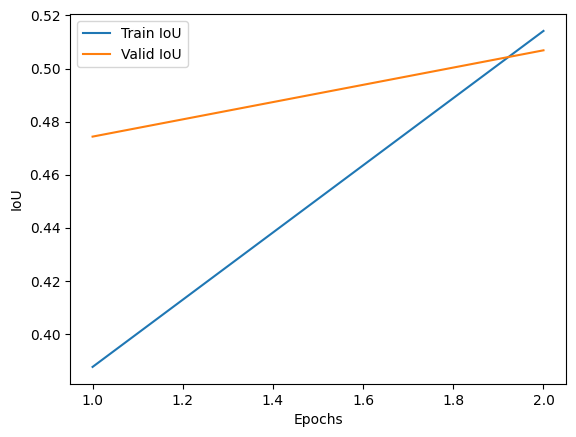


Epoch: 3
valid: 100%|██████████| 34/34 [00:07<00:00,  4.42it/s, cross_entropy_loss - 0.9598, iou_score - 0.5423]
Model saved!

Epoch: 4
valid: 100%|██████████| 34/34 [00:07<00:00,  4.36it/s, cross_entropy_loss - 0.9459, iou_score - 0.5554]
Model saved!


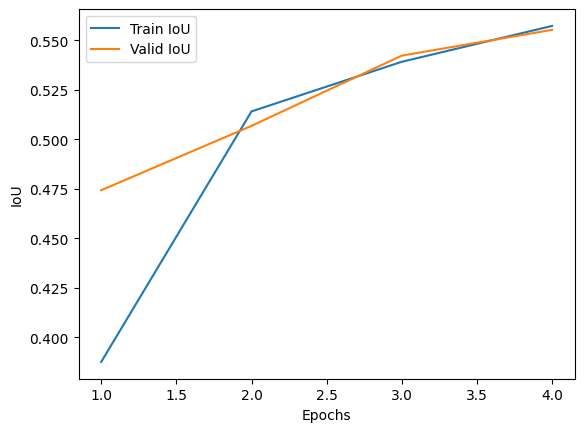


Epoch: 5
valid: 100%|██████████| 34/34 [00:06<00:00,  5.12it/s, cross_entropy_loss - 0.9439, iou_score - 0.577] 
Model saved!

Epoch: 6
valid: 100%|██████████| 34/34 [00:08<00:00,  4.16it/s, cross_entropy_loss - 0.9412, iou_score - 0.5754]


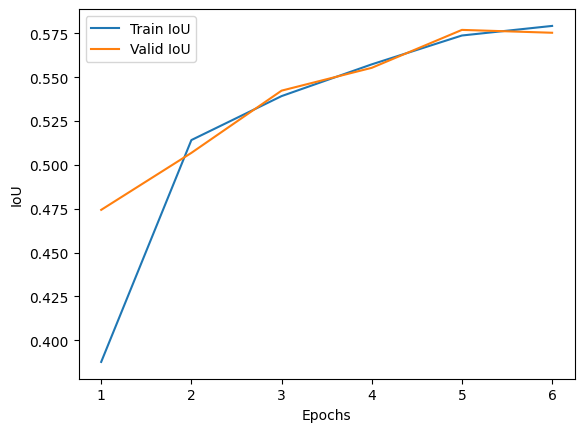


Epoch: 7
valid: 100%|██████████| 34/34 [00:07<00:00,  4.49it/s, cross_entropy_loss - 0.9382, iou_score - 0.6013]
Model saved!

Epoch: 8
valid: 100%|██████████| 34/34 [00:09<00:00,  3.65it/s, cross_entropy_loss - 0.9327, iou_score - 0.6122]
Model saved!


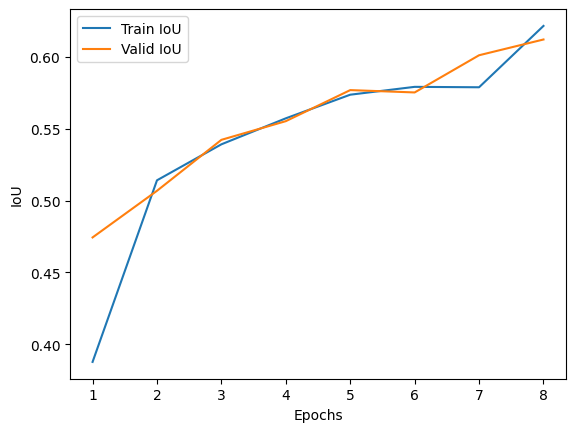


Epoch: 9
valid: 100%|██████████| 34/34 [00:07<00:00,  4.26it/s, cross_entropy_loss - 0.931, iou_score - 0.6155] 
Model saved!

Epoch: 10
valid: 100%|██████████| 34/34 [00:07<00:00,  4.49it/s, cross_entropy_loss - 0.9264, iou_score - 0.6347]
Model saved!


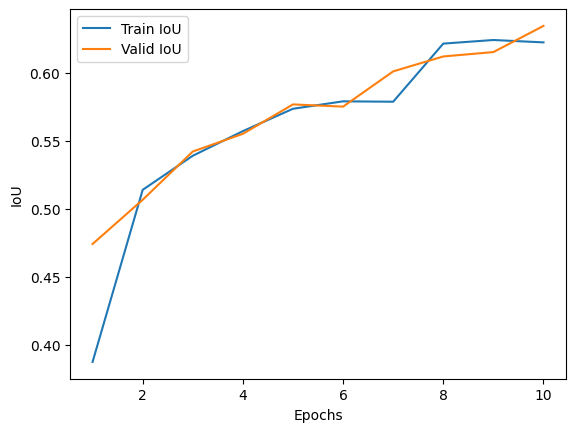


Epoch: 11
valid: 100%|██████████| 34/34 [00:07<00:00,  4.43it/s, cross_entropy_loss - 0.9285, iou_score - 0.6383]
Model saved!

Epoch: 12
valid: 100%|██████████| 34/34 [00:07<00:00,  4.43it/s, cross_entropy_loss - 0.9463, iou_score - 0.5651]


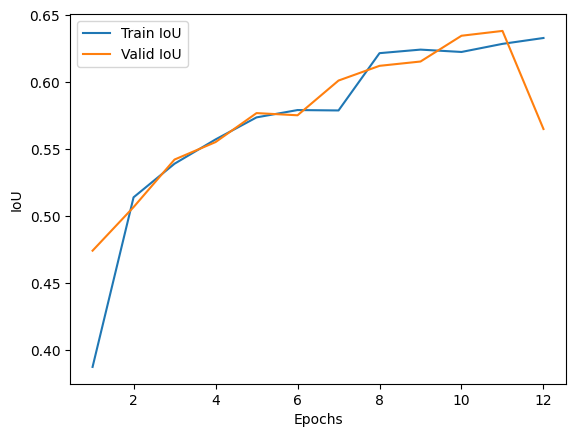


Epoch: 13
valid: 100%|██████████| 34/34 [00:07<00:00,  4.41it/s, cross_entropy_loss - 0.9257, iou_score - 0.6265]

Epoch: 14
valid: 100%|██████████| 34/34 [00:07<00:00,  4.43it/s, cross_entropy_loss - 0.9229, iou_score - 0.6407]
Model saved!


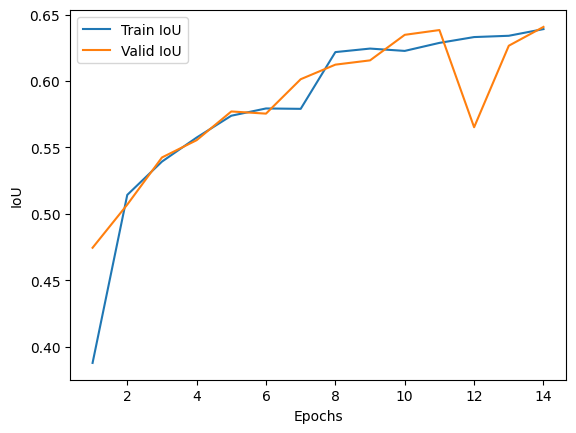


Epoch: 15
valid: 100%|██████████| 34/34 [00:07<00:00,  4.47it/s, cross_entropy_loss - 0.9195, iou_score - 0.6499]
Model saved!

Epoch: 16
valid: 100%|██████████| 34/34 [00:07<00:00,  4.76it/s, cross_entropy_loss - 0.921, iou_score - 0.6438] 


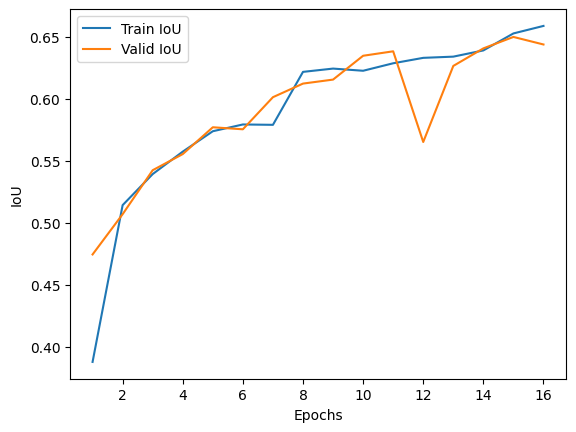


Epoch: 17
valid: 100%|██████████| 34/34 [00:07<00:00,  4.65it/s, cross_entropy_loss - 0.923, iou_score - 0.6512] 
Model saved!

Epoch: 18
valid: 100%|██████████| 34/34 [00:07<00:00,  4.78it/s, cross_entropy_loss - 0.9186, iou_score - 0.6486]


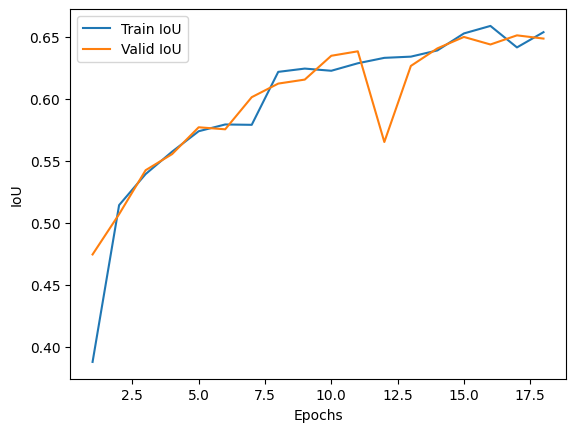


Epoch: 19
valid: 100%|██████████| 34/34 [00:07<00:00,  4.72it/s, cross_entropy_loss - 0.9228, iou_score - 0.6381]

Epoch: 20
valid: 100%|██████████| 34/34 [00:07<00:00,  4.65it/s, cross_entropy_loss - 0.9184, iou_score - 0.6621]
Model saved!


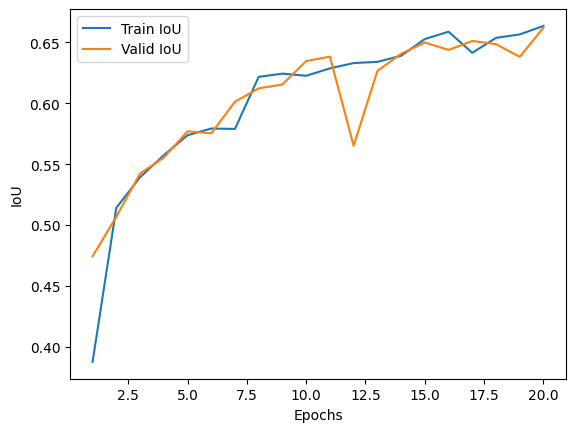


Epoch: 21
valid: 100%|██████████| 34/34 [00:07<00:00,  4.71it/s, cross_entropy_loss - 0.9198, iou_score - 0.6542]

Epoch: 22
valid: 100%|██████████| 34/34 [00:07<00:00,  4.75it/s, cross_entropy_loss - 0.9182, iou_score - 0.6633]
Model saved!


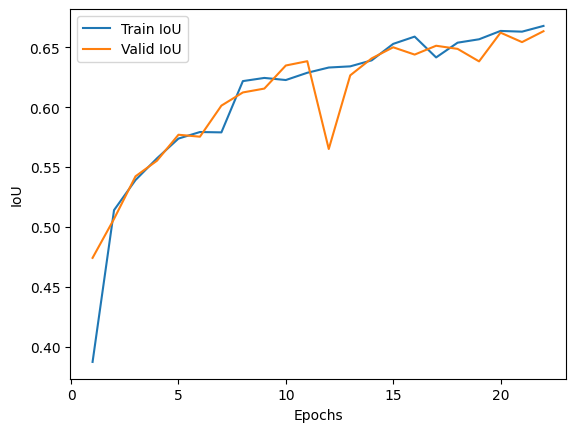


Epoch: 23
valid: 100%|██████████| 34/34 [00:07<00:00,  4.40it/s, cross_entropy_loss - 0.9179, iou_score - 0.6627]

Epoch: 24
valid: 100%|██████████| 34/34 [00:08<00:00,  4.25it/s, cross_entropy_loss - 0.9163, iou_score - 0.659] 


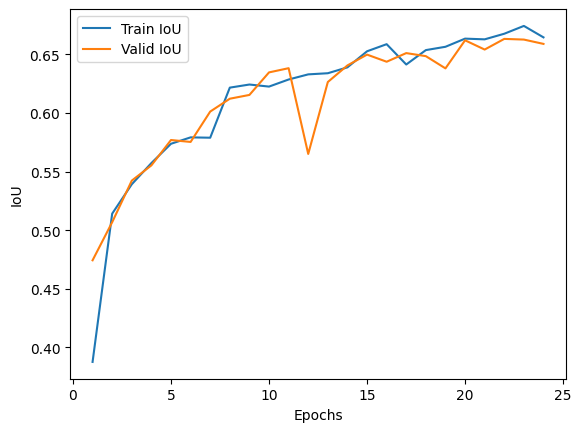


Epoch: 25
valid: 100%|██████████| 34/34 [00:07<00:00,  4.79it/s, cross_entropy_loss - 0.926, iou_score - 0.6353] 

Epoch: 26
valid: 100%|██████████| 34/34 [00:07<00:00,  4.26it/s, cross_entropy_loss - 0.9203, iou_score - 0.65]  


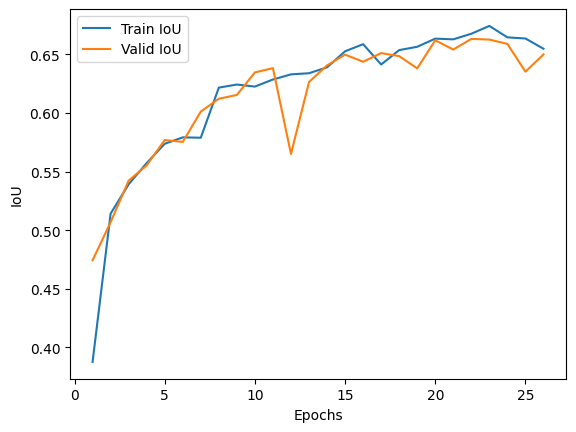


Epoch: 27
valid: 100%|██████████| 34/34 [00:07<00:00,  4.64it/s, cross_entropy_loss - 0.925, iou_score - 0.6551] 

Epoch: 28
valid: 100%|██████████| 34/34 [00:07<00:00,  4.35it/s, cross_entropy_loss - 0.9222, iou_score - 0.6425]


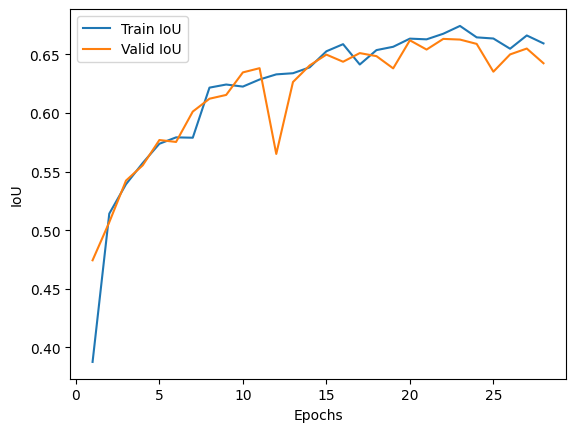


Epoch: 29
valid: 100%|██████████| 34/34 [00:07<00:00,  4.71it/s, cross_entropy_loss - 0.9317, iou_score - 0.6495]

Epoch: 30
valid: 100%|██████████| 34/34 [00:07<00:00,  4.67it/s, cross_entropy_loss - 0.9149, iou_score - 0.6759]
Model saved!


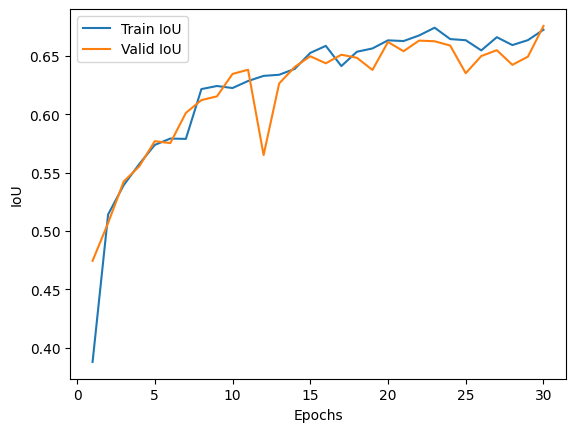


Epoch: 31
valid: 100%|██████████| 34/34 [00:07<00:00,  4.74it/s, cross_entropy_loss - 0.9191, iou_score - 0.6578]

Epoch: 32
valid: 100%|██████████| 34/34 [00:07<00:00,  4.77it/s, cross_entropy_loss - 0.916, iou_score - 0.6615] 


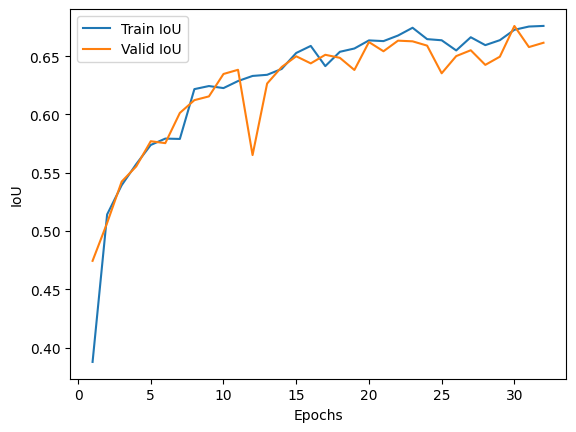


Epoch: 33
valid: 100%|██████████| 34/34 [00:07<00:00,  4.69it/s, cross_entropy_loss - 0.9161, iou_score - 0.6726]

Epoch: 34
valid: 100%|██████████| 34/34 [00:07<00:00,  4.63it/s, cross_entropy_loss - 0.9155, iou_score - 0.6802]
Model saved!


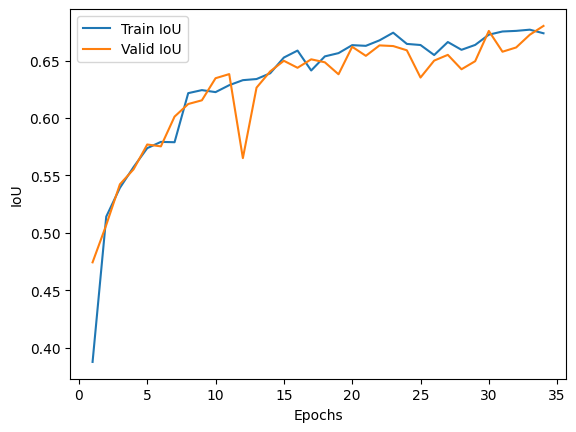


Epoch: 35
valid: 100%|██████████| 34/34 [00:07<00:00,  4.50it/s, cross_entropy_loss - 0.917, iou_score - 0.6686] 

Epoch: 36
valid: 100%|██████████| 34/34 [00:07<00:00,  4.58it/s, cross_entropy_loss - 0.9173, iou_score - 0.6719]


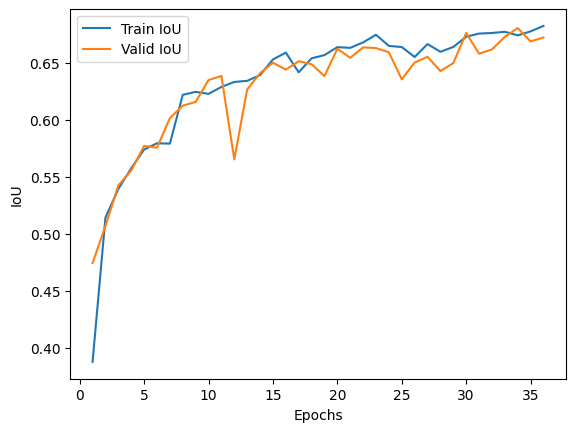


Epoch: 37
valid: 100%|██████████| 34/34 [00:07<00:00,  4.59it/s, cross_entropy_loss - 0.9167, iou_score - 0.6728]

Epoch: 38
valid: 100%|██████████| 34/34 [00:09<00:00,  3.78it/s, cross_entropy_loss - 0.9194, iou_score - 0.6613]


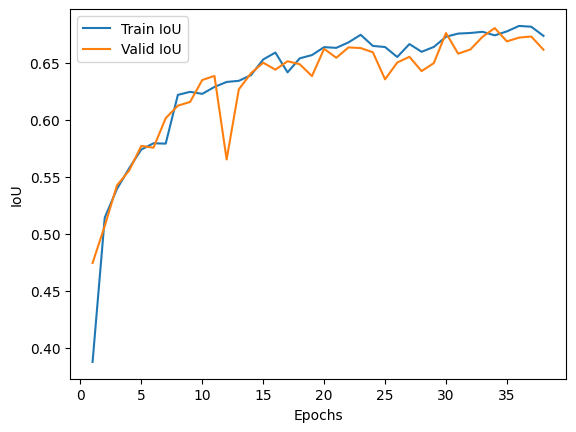


Epoch: 39
valid: 100%|██████████| 34/34 [00:09<00:00,  3.61it/s, cross_entropy_loss - 0.9155, iou_score - 0.6683]

Epoch: 40
valid: 100%|██████████| 34/34 [00:08<00:00,  4.05it/s, cross_entropy_loss - 0.916, iou_score - 0.6673] 


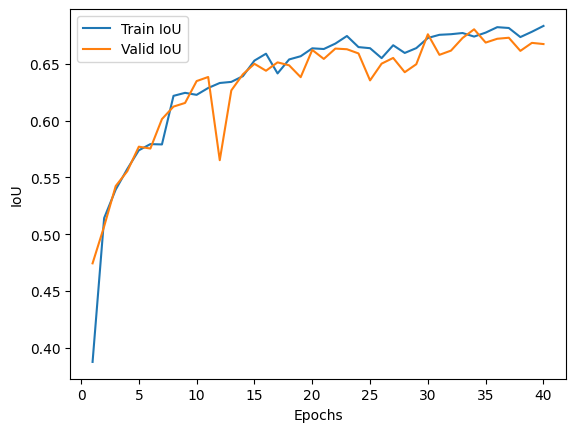


Epoch: 41
valid: 100%|██████████| 34/34 [00:07<00:00,  4.81it/s, cross_entropy_loss - 0.9192, iou_score - 0.6757]

Epoch: 42
valid: 100%|██████████| 34/34 [00:08<00:00,  3.78it/s, cross_entropy_loss - 0.9182, iou_score - 0.6705]


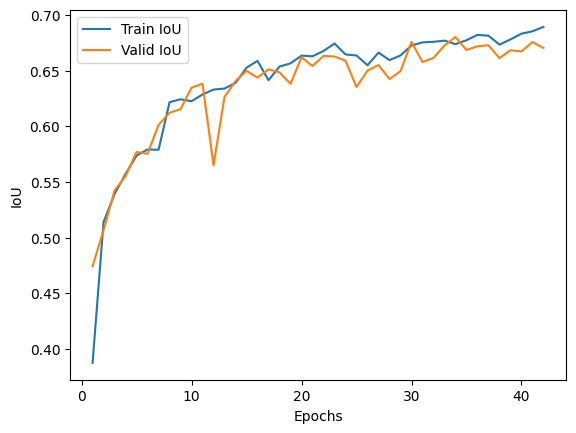


Epoch: 43
valid: 100%|██████████| 34/34 [00:08<00:00,  4.13it/s, cross_entropy_loss - 0.9168, iou_score - 0.6683]

Epoch: 44
valid: 100%|██████████| 34/34 [00:08<00:00,  4.24it/s, cross_entropy_loss - 0.9128, iou_score - 0.6696]


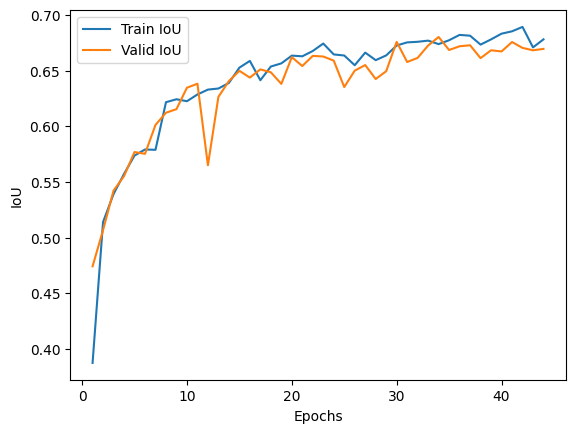


Epoch: 45
valid: 100%|██████████| 34/34 [00:08<00:00,  4.14it/s, cross_entropy_loss - 0.9143, iou_score - 0.6777]

Epoch: 46
valid: 100%|██████████| 34/34 [00:08<00:00,  4.10it/s, cross_entropy_loss - 0.9156, iou_score - 0.6712]


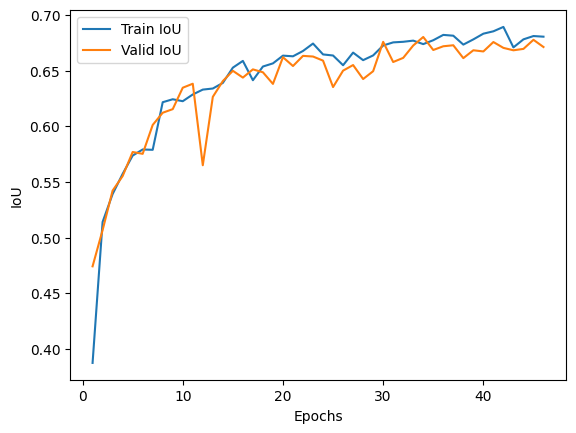


Epoch: 47
valid: 100%|██████████| 34/34 [00:08<00:00,  3.80it/s, cross_entropy_loss - 0.9178, iou_score - 0.6751]

Epoch: 48
valid: 100%|██████████| 34/34 [00:08<00:00,  4.06it/s, cross_entropy_loss - 0.9153, iou_score - 0.6852]
Model saved!


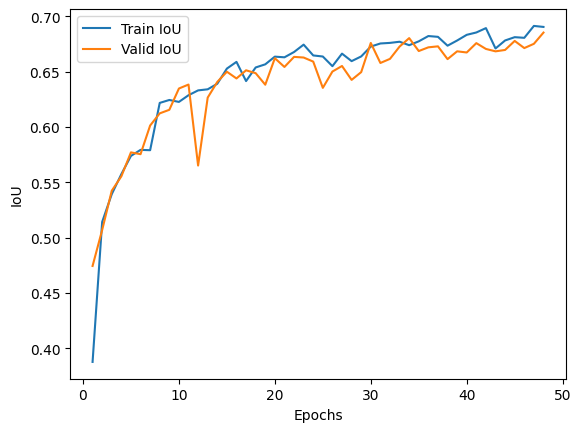


Epoch: 49
valid: 100%|██████████| 34/34 [00:08<00:00,  4.01it/s, cross_entropy_loss - 0.9141, iou_score - 0.6855]
Model saved!

Epoch: 50
valid: 100%|██████████| 34/34 [00:08<00:00,  4.03it/s, cross_entropy_loss - 0.9221, iou_score - 0.6795]


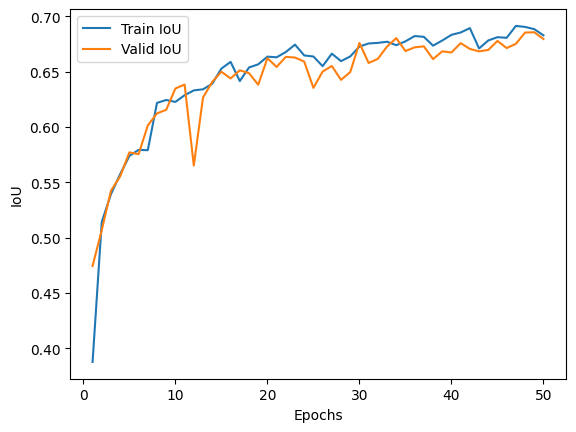


Epoch: 1
valid: 100%|██████████| 34/34 [00:08<00:00,  4.13it/s, cross_entropy_loss - 0.9925, iou_score - 0.4587]
Model saved!

Epoch: 2
valid: 100%|██████████| 34/34 [00:07<00:00,  4.33it/s, cross_entropy_loss - 0.9397, iou_score - 0.5759]
Model saved!


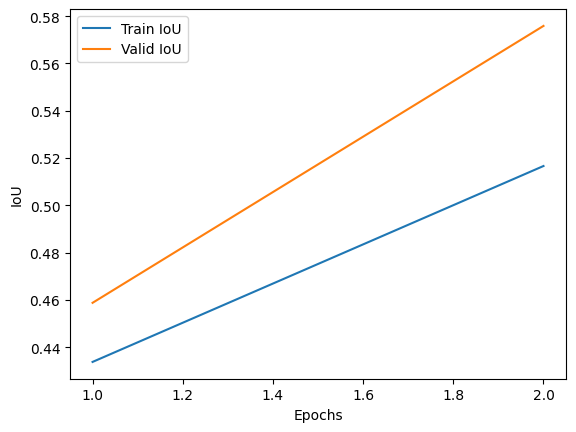


Epoch: 3
valid: 100%|██████████| 34/34 [00:08<00:00,  4.25it/s, cross_entropy_loss - 0.9472, iou_score - 0.5453]

Epoch: 4
valid: 100%|██████████| 34/34 [00:08<00:00,  4.18it/s, cross_entropy_loss - 0.9324, iou_score - 0.5979]
Model saved!


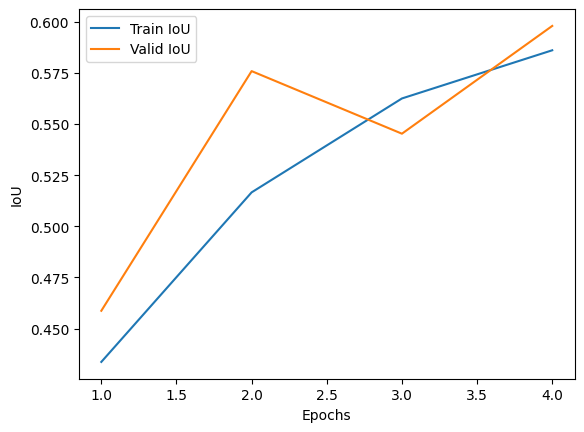


Epoch: 5
valid: 100%|██████████| 34/34 [00:08<00:00,  4.16it/s, cross_entropy_loss - 0.9339, iou_score - 0.6037]
Model saved!

Epoch: 6
valid: 100%|██████████| 34/34 [00:08<00:00,  4.16it/s, cross_entropy_loss - 0.9352, iou_score - 0.6162]
Model saved!


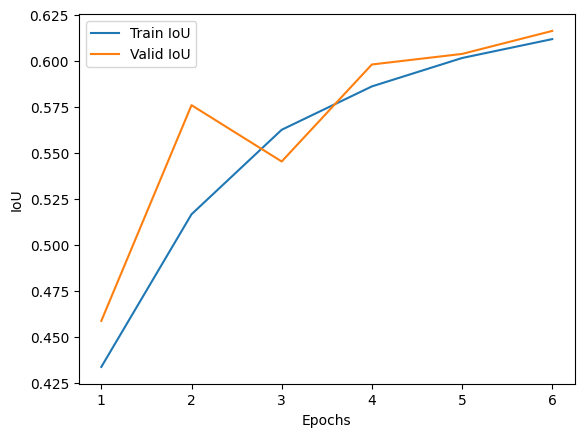


Epoch: 7
valid: 100%|██████████| 34/34 [00:07<00:00,  4.35it/s, cross_entropy_loss - 0.9416, iou_score - 0.5784]

Epoch: 8
valid: 100%|██████████| 34/34 [00:07<00:00,  4.33it/s, cross_entropy_loss - 0.9294, iou_score - 0.6205]
Model saved!


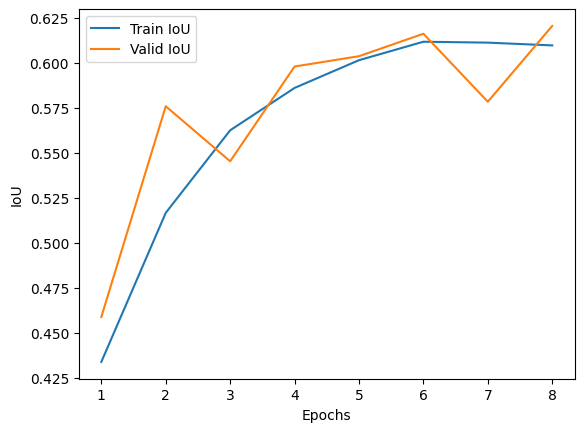


Epoch: 9
valid: 100%|██████████| 34/34 [00:07<00:00,  4.50it/s, cross_entropy_loss - 0.932, iou_score - 0.6155] 

Epoch: 10
valid: 100%|██████████| 34/34 [00:07<00:00,  4.41it/s, cross_entropy_loss - 0.9264, iou_score - 0.6151]


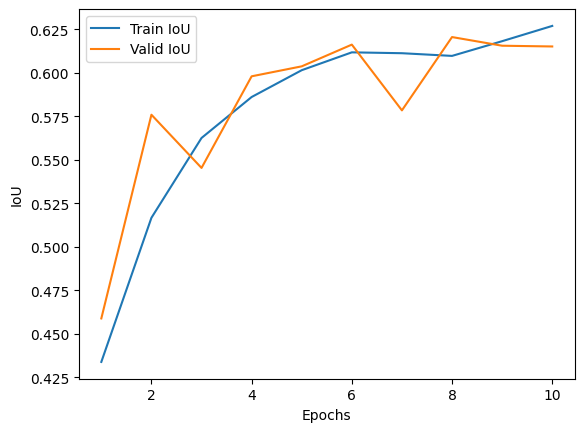


Epoch: 11
valid: 100%|██████████| 34/34 [00:06<00:00,  4.91it/s, cross_entropy_loss - 0.9289, iou_score - 0.6102]

Epoch: 12
valid: 100%|██████████| 34/34 [00:06<00:00,  5.00it/s, cross_entropy_loss - 0.9294, iou_score - 0.6307]
Model saved!


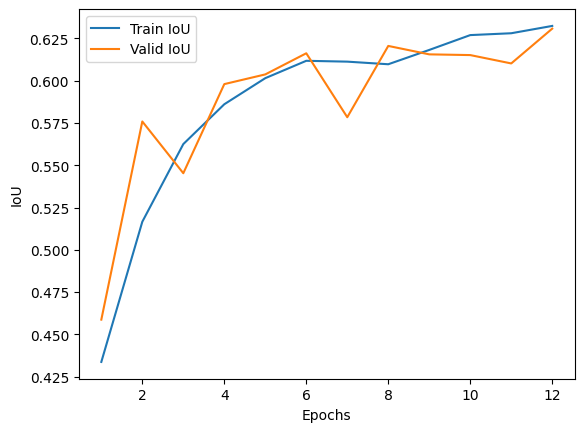


Epoch: 13
valid: 100%|██████████| 34/34 [00:06<00:00,  4.91it/s, cross_entropy_loss - 0.9255, iou_score - 0.6299]

Epoch: 14
valid: 100%|██████████| 34/34 [00:06<00:00,  4.99it/s, cross_entropy_loss - 0.9287, iou_score - 0.6087]


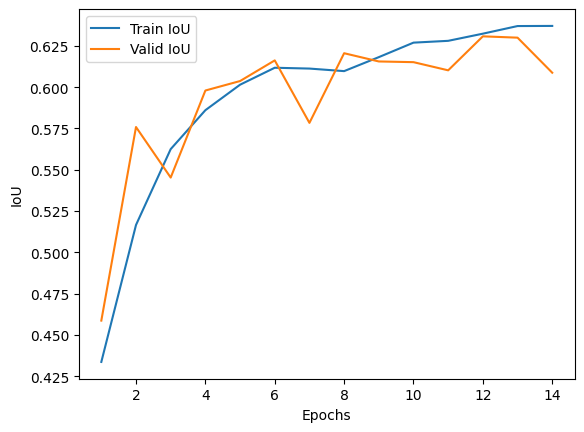


Epoch: 15
valid: 100%|██████████| 34/34 [00:08<00:00,  4.13it/s, cross_entropy_loss - 0.9311, iou_score - 0.6214]

Epoch: 16
valid: 100%|██████████| 34/34 [00:07<00:00,  4.26it/s, cross_entropy_loss - 0.9249, iou_score - 0.6495]
Model saved!


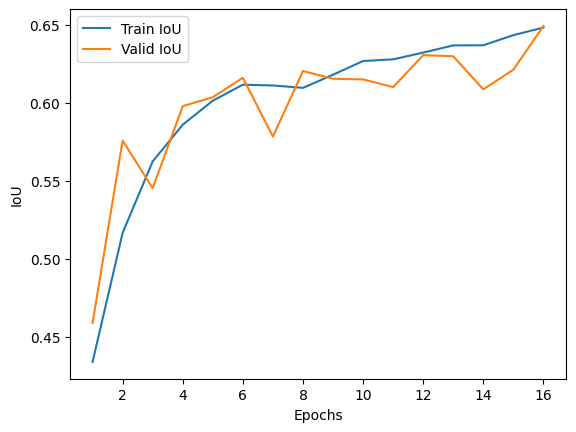


Epoch: 17
valid: 100%|██████████| 34/34 [00:08<00:00,  4.25it/s, cross_entropy_loss - 0.9568, iou_score - 0.5345]

Epoch: 18
valid: 100%|██████████| 34/34 [00:08<00:00,  4.13it/s, cross_entropy_loss - 0.9222, iou_score - 0.6504]
Model saved!


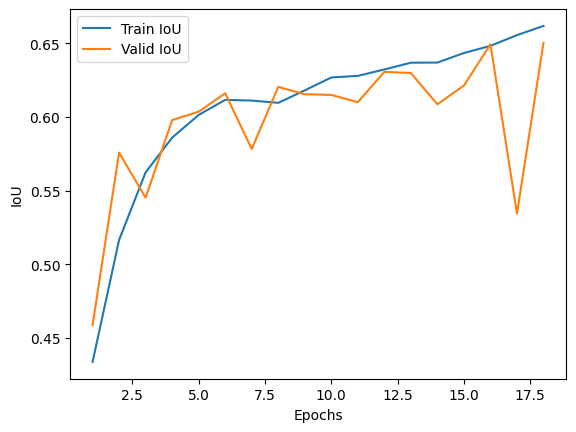


Epoch: 19
valid: 100%|██████████| 34/34 [00:07<00:00,  4.26it/s, cross_entropy_loss - 0.9241, iou_score - 0.6431]

Epoch: 20
valid: 100%|██████████| 34/34 [00:07<00:00,  4.48it/s, cross_entropy_loss - 0.9322, iou_score - 0.5937]


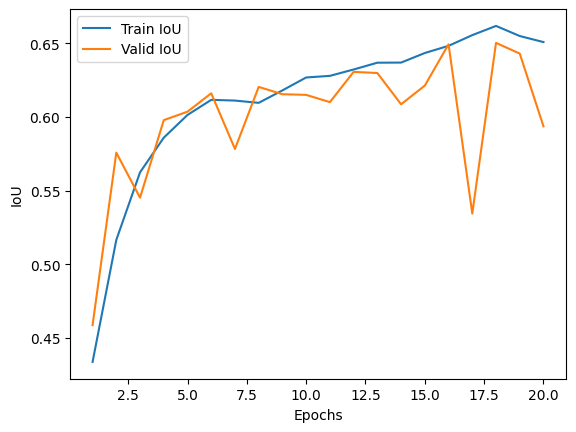


Epoch: 21
valid: 100%|██████████| 34/34 [00:08<00:00,  4.18it/s, cross_entropy_loss - 0.9249, iou_score - 0.658] 
Model saved!

Epoch: 22
valid: 100%|██████████| 34/34 [00:07<00:00,  4.46it/s, cross_entropy_loss - 0.9306, iou_score - 0.6078]


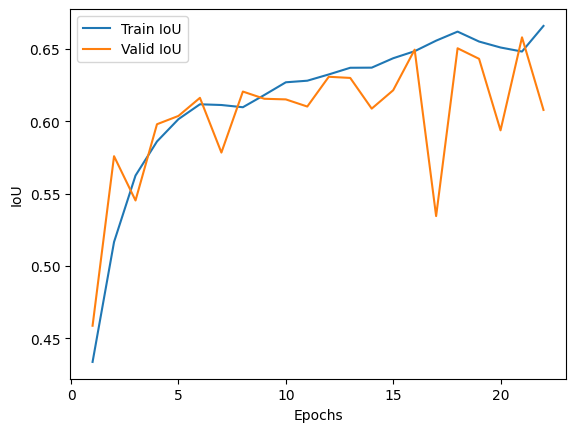


Epoch: 23
valid: 100%|██████████| 34/34 [00:07<00:00,  4.52it/s, cross_entropy_loss - 0.921, iou_score - 0.6422] 

Epoch: 24
valid: 100%|██████████| 34/34 [00:06<00:00,  4.97it/s, cross_entropy_loss - 0.9286, iou_score - 0.6397]


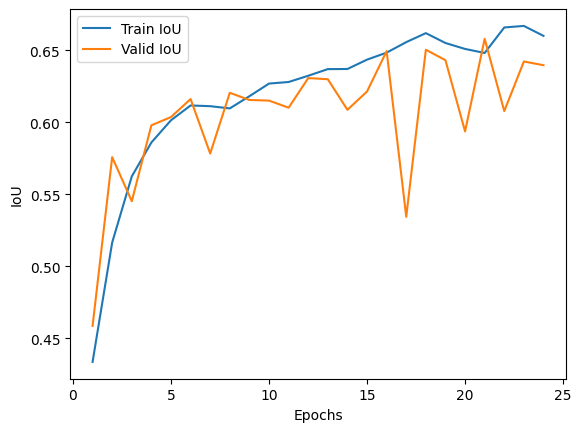


Epoch: 25
valid: 100%|██████████| 34/34 [00:07<00:00,  4.30it/s, cross_entropy_loss - 0.9186, iou_score - 0.6622]
Model saved!

Epoch: 26
valid: 100%|██████████| 34/34 [00:06<00:00,  4.92it/s, cross_entropy_loss - 0.9212, iou_score - 0.6656]
Model saved!


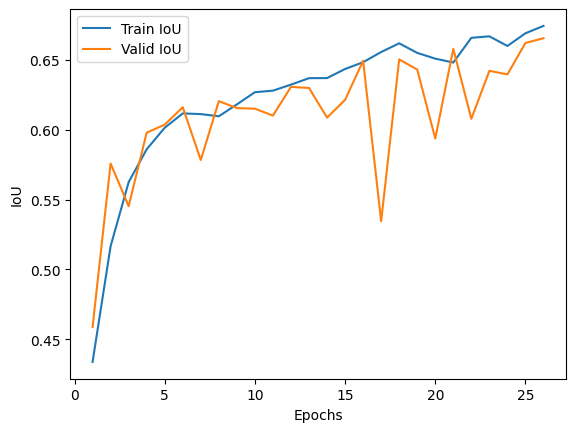


Epoch: 27
valid: 100%|██████████| 34/34 [00:07<00:00,  4.57it/s, cross_entropy_loss - 0.9181, iou_score - 0.6587]

Epoch: 28
valid: 100%|██████████| 34/34 [00:07<00:00,  4.40it/s, cross_entropy_loss - 0.9234, iou_score - 0.6577]


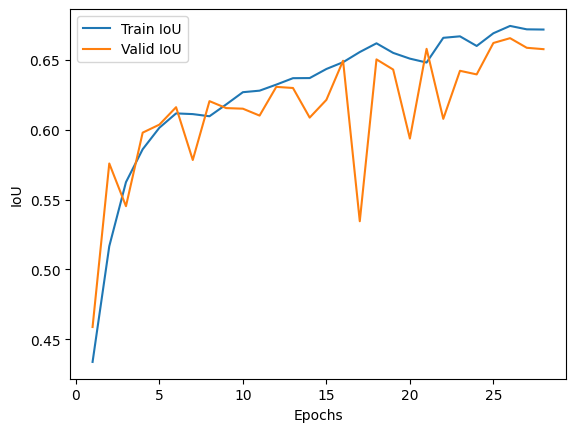


Epoch: 29
valid: 100%|██████████| 34/34 [00:07<00:00,  4.80it/s, cross_entropy_loss - 0.9199, iou_score - 0.6731]
Model saved!

Epoch: 30
valid: 100%|██████████| 34/34 [00:07<00:00,  4.63it/s, cross_entropy_loss - 0.9215, iou_score - 0.67]  


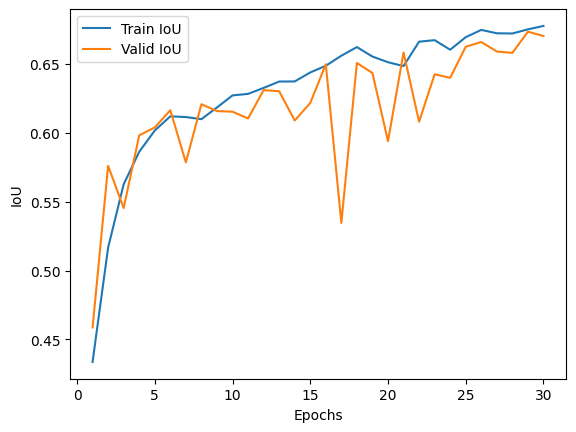


Epoch: 31
valid: 100%|██████████| 34/34 [00:07<00:00,  4.49it/s, cross_entropy_loss - 0.9199, iou_score - 0.674] 
Model saved!

Epoch: 32
valid: 100%|██████████| 34/34 [00:06<00:00,  4.88it/s, cross_entropy_loss - 0.9183, iou_score - 0.676] 
Model saved!


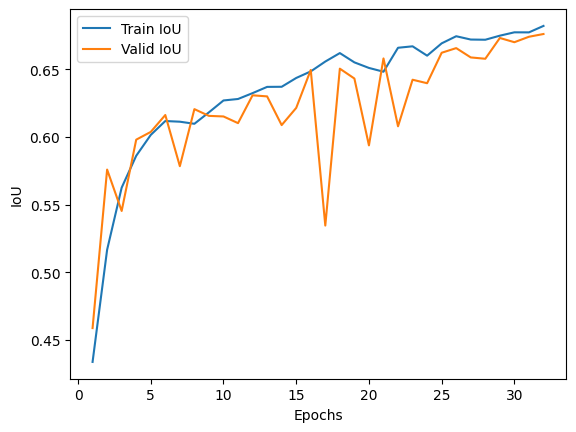


Epoch: 33
valid: 100%|██████████| 34/34 [00:07<00:00,  4.78it/s, cross_entropy_loss - 0.9223, iou_score - 0.645] 

Epoch: 34
valid: 100%|██████████| 34/34 [00:08<00:00,  4.21it/s, cross_entropy_loss - 0.9185, iou_score - 0.6498]


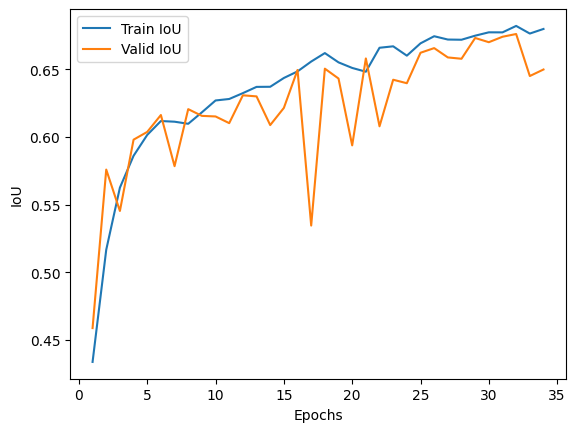


Epoch: 35
valid: 100%|██████████| 34/34 [00:07<00:00,  4.77it/s, cross_entropy_loss - 0.9172, iou_score - 0.6785]
Model saved!

Epoch: 36
valid: 100%|██████████| 34/34 [00:07<00:00,  4.53it/s, cross_entropy_loss - 0.9161, iou_score - 0.656] 


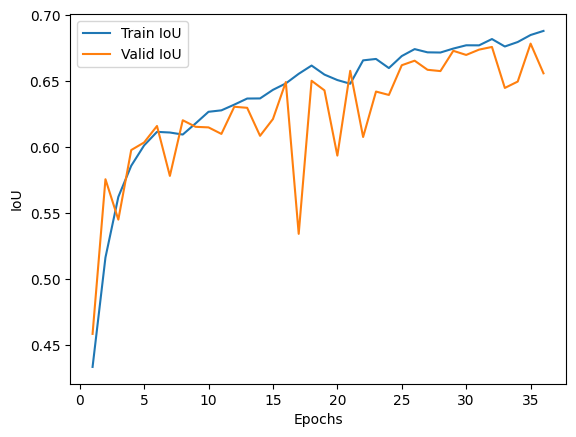


Epoch: 37
valid: 100%|██████████| 34/34 [00:07<00:00,  4.52it/s, cross_entropy_loss - 0.9177, iou_score - 0.6836]
Model saved!

Epoch: 38
valid: 100%|██████████| 34/34 [00:07<00:00,  4.59it/s, cross_entropy_loss - 0.9171, iou_score - 0.6906]
Model saved!


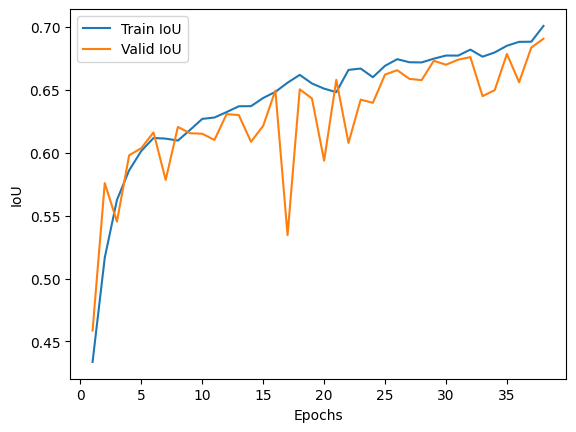


Epoch: 39
valid: 100%|██████████| 34/34 [00:07<00:00,  4.56it/s, cross_entropy_loss - 0.9166, iou_score - 0.6837]

Epoch: 40
valid: 100%|██████████| 34/34 [00:07<00:00,  4.49it/s, cross_entropy_loss - 0.9254, iou_score - 0.6774]


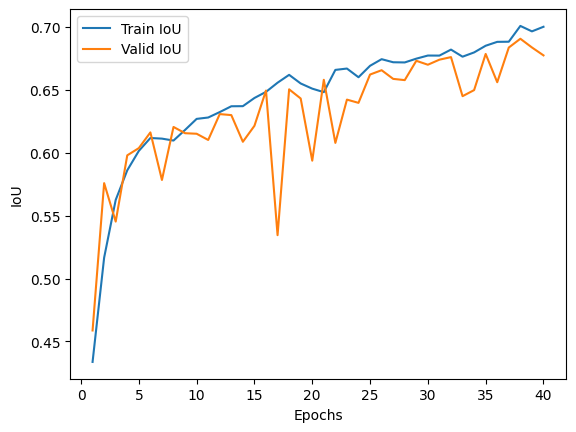


Epoch: 41
valid: 100%|██████████| 34/34 [00:07<00:00,  4.46it/s, cross_entropy_loss - 0.9153, iou_score - 0.6826]

Epoch: 42
valid: 100%|██████████| 34/34 [00:07<00:00,  4.62it/s, cross_entropy_loss - 0.9181, iou_score - 0.6905]


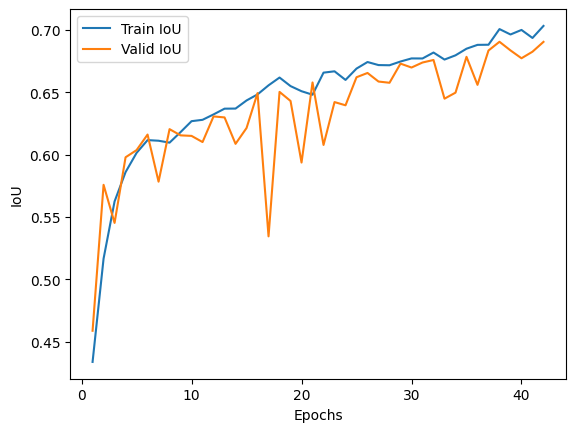


Epoch: 43
valid: 100%|██████████| 34/34 [00:07<00:00,  4.50it/s, cross_entropy_loss - 0.9207, iou_score - 0.6809]

Epoch: 44
valid: 100%|██████████| 34/34 [00:07<00:00,  4.37it/s, cross_entropy_loss - 0.9202, iou_score - 0.6663]


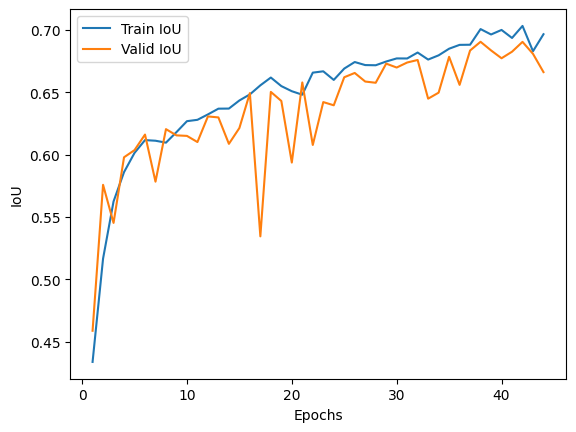


Epoch: 45
valid: 100%|██████████| 34/34 [00:07<00:00,  4.51it/s, cross_entropy_loss - 0.9173, iou_score - 0.661] 

Epoch: 46
valid: 100%|██████████| 34/34 [00:07<00:00,  4.45it/s, cross_entropy_loss - 0.9151, iou_score - 0.6852]


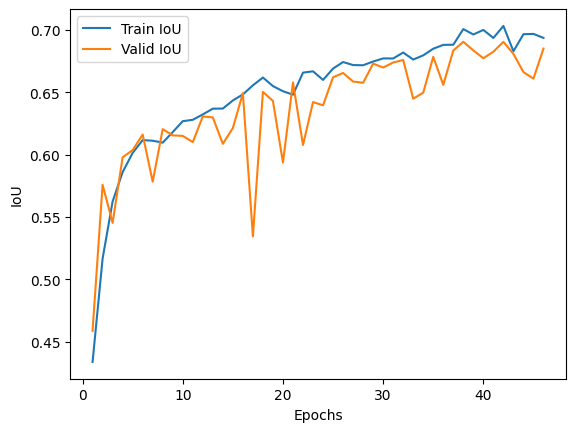


Epoch: 47
valid: 100%|██████████| 34/34 [00:07<00:00,  4.59it/s, cross_entropy_loss - 0.9191, iou_score - 0.6795]

Epoch: 48
valid: 100%|██████████| 34/34 [00:08<00:00,  4.25it/s, cross_entropy_loss - 0.916, iou_score - 0.6982] 
Model saved!


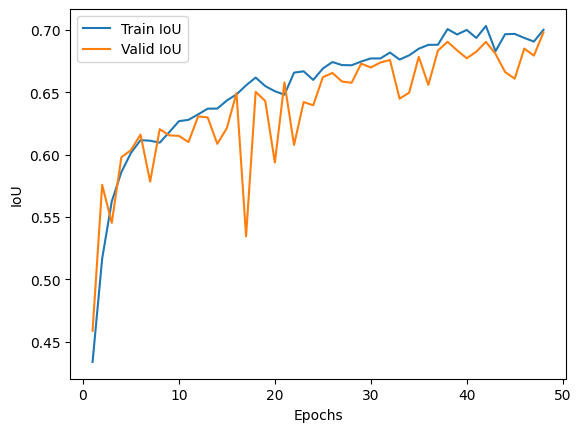


Epoch: 49
valid: 100%|██████████| 34/34 [00:07<00:00,  4.79it/s, cross_entropy_loss - 0.9165, iou_score - 0.6911]

Epoch: 50
valid: 100%|██████████| 34/34 [00:07<00:00,  4.82it/s, cross_entropy_loss - 0.9143, iou_score - 0.6891]


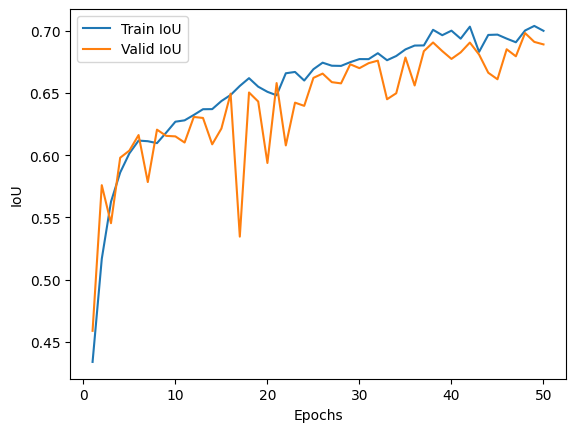


Epoch: 1
valid: 100%|██████████| 34/34 [00:05<00:00,  5.85it/s, cross_entropy_loss - 0.9729, iou_score - 0.5116]
Model saved!

Epoch: 2
valid: 100%|██████████| 34/34 [00:05<00:00,  5.89it/s, cross_entropy_loss - 0.9488, iou_score - 0.5647]
Model saved!


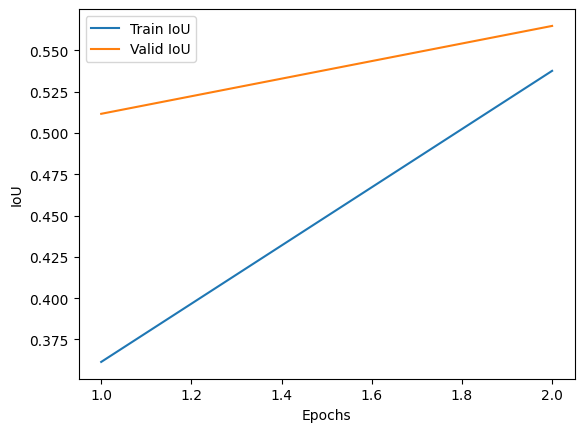


Epoch: 3
valid: 100%|██████████| 34/34 [00:05<00:00,  5.85it/s, cross_entropy_loss - 0.9351, iou_score - 0.6041]
Model saved!

Epoch: 4
valid: 100%|██████████| 34/34 [00:05<00:00,  5.92it/s, cross_entropy_loss - 0.932, iou_score - 0.612]  
Model saved!


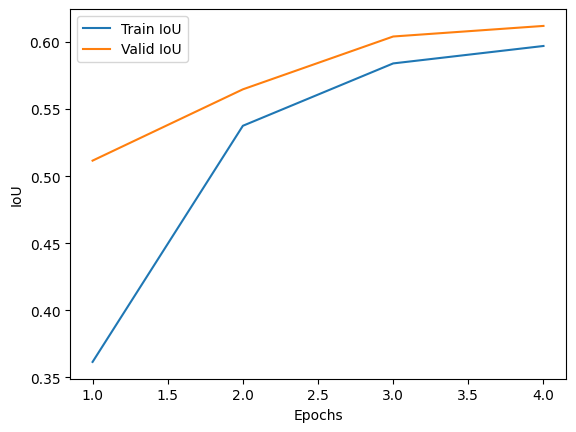


Epoch: 5
valid: 100%|██████████| 34/34 [00:05<00:00,  5.99it/s, cross_entropy_loss - 0.9384, iou_score - 0.6133]
Model saved!

Epoch: 6
valid: 100%|██████████| 34/34 [00:05<00:00,  5.90it/s, cross_entropy_loss - 0.9309, iou_score - 0.615] 
Model saved!


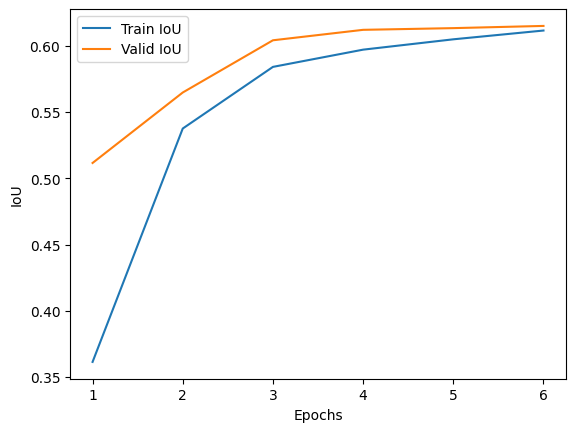


Epoch: 7
valid: 100%|██████████| 34/34 [00:05<00:00,  5.93it/s, cross_entropy_loss - 0.9267, iou_score - 0.6441]
Model saved!

Epoch: 8
valid: 100%|██████████| 34/34 [00:05<00:00,  5.96it/s, cross_entropy_loss - 0.948, iou_score - 0.585]  


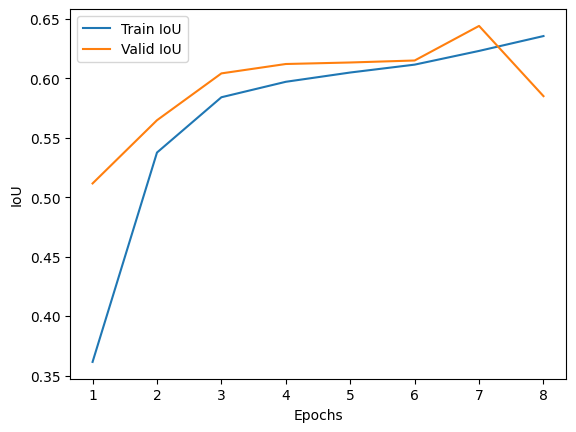


Epoch: 9
valid: 100%|██████████| 34/34 [00:05<00:00,  5.91it/s, cross_entropy_loss - 0.9217, iou_score - 0.6483]
Model saved!

Epoch: 10
valid: 100%|██████████| 34/34 [00:06<00:00,  5.55it/s, cross_entropy_loss - 0.9207, iou_score - 0.6492]
Model saved!


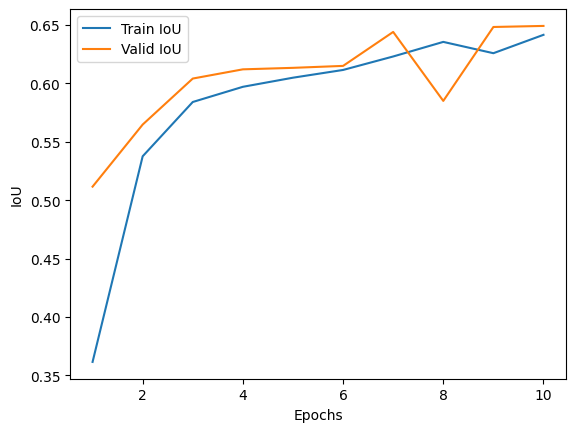


Epoch: 11
valid: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s, cross_entropy_loss - 0.9213, iou_score - 0.6536]
Model saved!

Epoch: 12
valid: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s, cross_entropy_loss - 0.9186, iou_score - 0.6545]
Model saved!


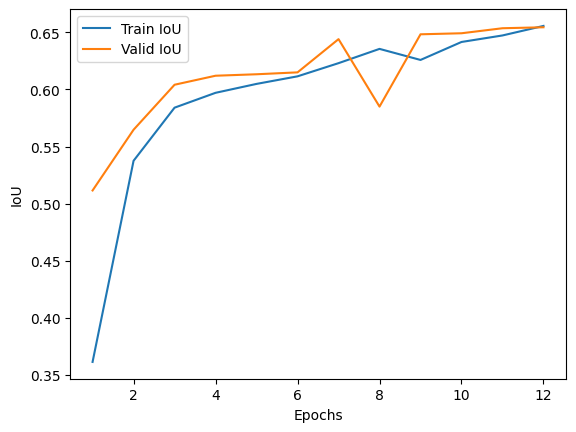


Epoch: 13
valid: 100%|██████████| 34/34 [00:05<00:00,  5.87it/s, cross_entropy_loss - 0.923, iou_score - 0.6458] 

Epoch: 14
valid: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s, cross_entropy_loss - 0.9204, iou_score - 0.6566]
Model saved!


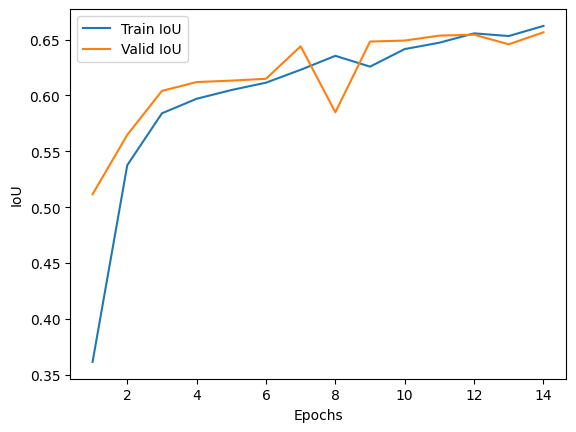


Epoch: 15
valid: 100%|██████████| 34/34 [00:05<00:00,  5.93it/s, cross_entropy_loss - 0.9202, iou_score - 0.6704]
Model saved!

Epoch: 16
valid: 100%|██████████| 34/34 [00:05<00:00,  5.91it/s, cross_entropy_loss - 0.9313, iou_score - 0.6444]


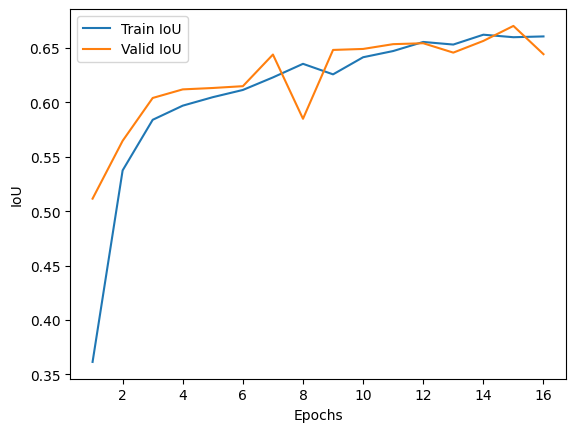


Epoch: 17
valid: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s, cross_entropy_loss - 0.9185, iou_score - 0.6633]

Epoch: 18
valid: 100%|██████████| 34/34 [00:05<00:00,  5.86it/s, cross_entropy_loss - 0.9175, iou_score - 0.6683]


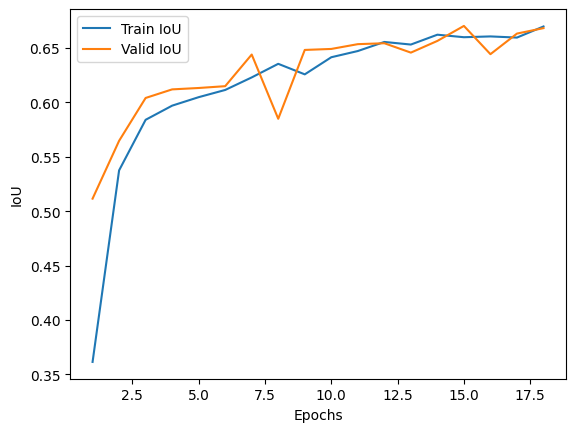


Epoch: 19
valid: 100%|██████████| 34/34 [00:05<00:00,  5.89it/s, cross_entropy_loss - 0.9161, iou_score - 0.6696]

Epoch: 20
valid: 100%|██████████| 34/34 [00:05<00:00,  5.82it/s, cross_entropy_loss - 0.9202, iou_score - 0.6653]


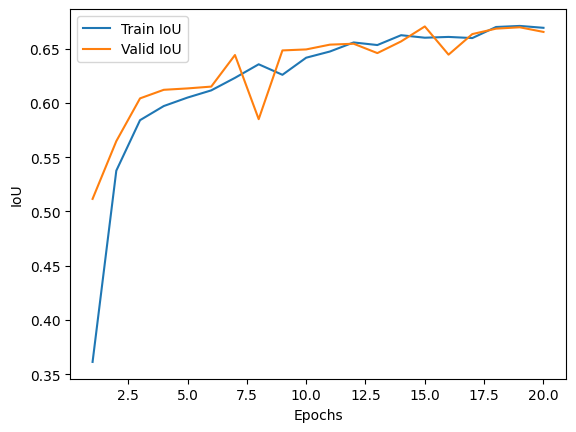


Epoch: 21
valid: 100%|██████████| 34/34 [00:05<00:00,  5.96it/s, cross_entropy_loss - 0.9181, iou_score - 0.6747]
Model saved!

Epoch: 22
valid: 100%|██████████| 34/34 [00:05<00:00,  5.99it/s, cross_entropy_loss - 0.9192, iou_score - 0.6667]


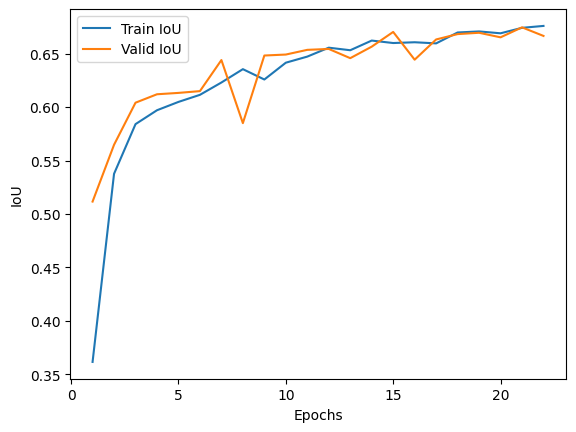


Epoch: 23
valid: 100%|██████████| 34/34 [00:05<00:00,  5.87it/s, cross_entropy_loss - 0.9162, iou_score - 0.6652]

Epoch: 24
valid: 100%|██████████| 34/34 [00:05<00:00,  5.90it/s, cross_entropy_loss - 0.9179, iou_score - 0.6721]


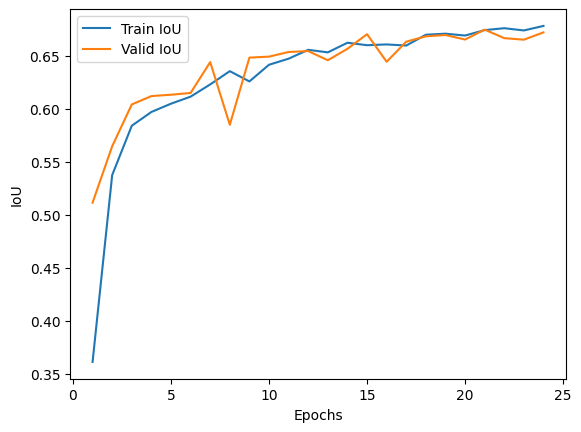


Epoch: 25
valid: 100%|██████████| 34/34 [00:05<00:00,  5.82it/s, cross_entropy_loss - 0.9269, iou_score - 0.6266]

Epoch: 26
valid: 100%|██████████| 34/34 [00:05<00:00,  5.93it/s, cross_entropy_loss - 0.9194, iou_score - 0.6571]


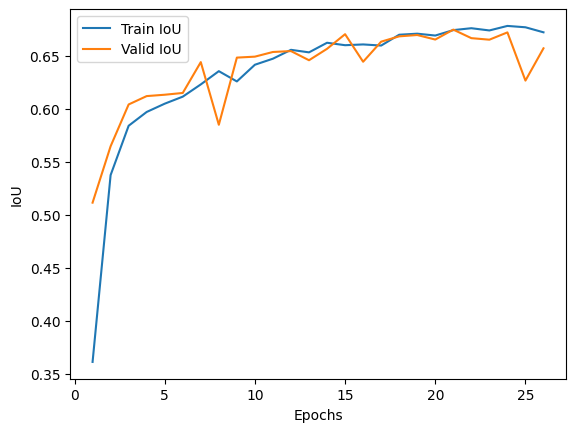


Epoch: 27
valid: 100%|██████████| 34/34 [00:05<00:00,  6.02it/s, cross_entropy_loss - 0.9172, iou_score - 0.6657]

Epoch: 28
valid: 100%|██████████| 34/34 [00:05<00:00,  5.84it/s, cross_entropy_loss - 0.9159, iou_score - 0.6771]
Model saved!


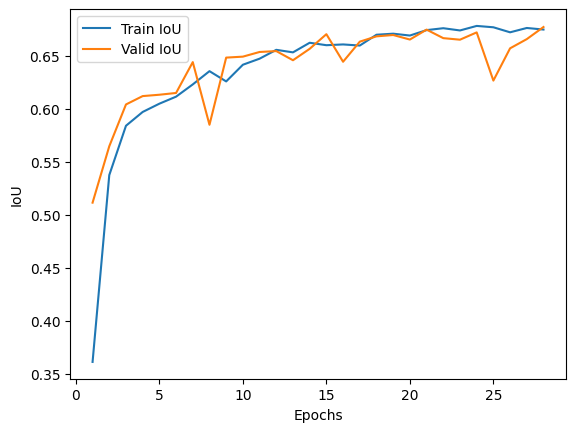


Epoch: 29
valid: 100%|██████████| 34/34 [00:05<00:00,  5.93it/s, cross_entropy_loss - 0.9193, iou_score - 0.6717]

Epoch: 30
valid: 100%|██████████| 34/34 [00:05<00:00,  5.94it/s, cross_entropy_loss - 0.9172, iou_score - 0.6792]
Model saved!


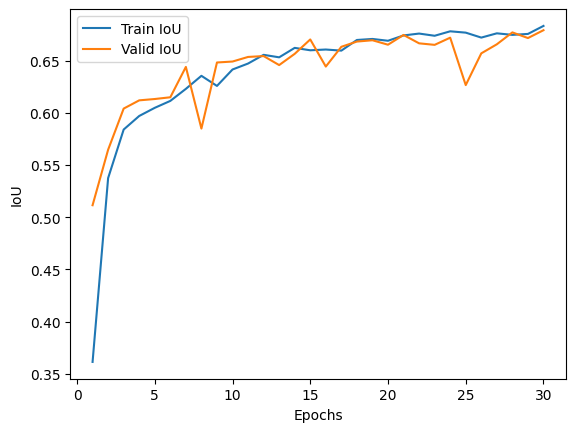


Epoch: 31
valid: 100%|██████████| 34/34 [00:05<00:00,  5.87it/s, cross_entropy_loss - 0.9183, iou_score - 0.6787]

Epoch: 32
valid: 100%|██████████| 34/34 [00:06<00:00,  5.58it/s, cross_entropy_loss - 0.9174, iou_score - 0.6809]
Model saved!


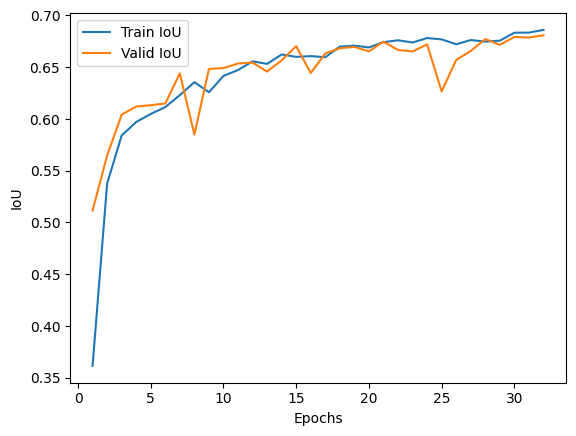


Epoch: 33
valid: 100%|██████████| 34/34 [00:05<00:00,  5.86it/s, cross_entropy_loss - 0.9145, iou_score - 0.6825]
Model saved!

Epoch: 34
valid: 100%|██████████| 34/34 [00:05<00:00,  5.87it/s, cross_entropy_loss - 0.9157, iou_score - 0.6828]
Model saved!


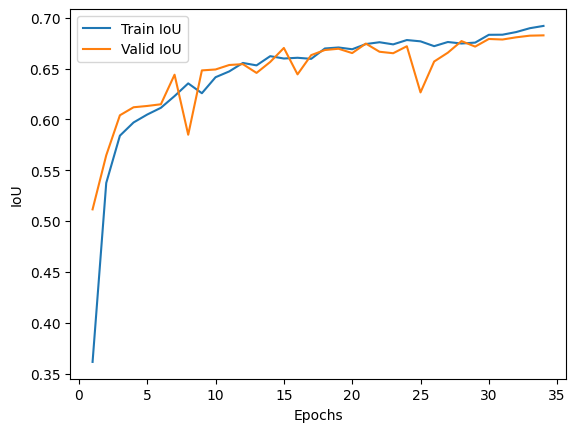


Epoch: 35
valid: 100%|██████████| 34/34 [00:05<00:00,  5.91it/s, cross_entropy_loss - 0.9179, iou_score - 0.6664]

Epoch: 36
valid: 100%|██████████| 34/34 [00:05<00:00,  5.97it/s, cross_entropy_loss - 0.9129, iou_score - 0.6951]
Model saved!


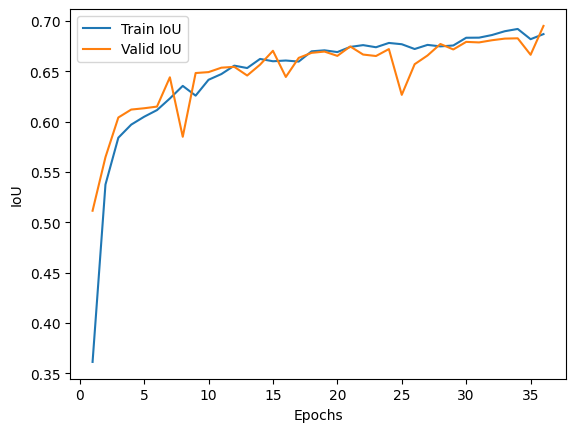


Epoch: 37
valid: 100%|██████████| 34/34 [00:05<00:00,  5.96it/s, cross_entropy_loss - 0.9139, iou_score - 0.6807]

Epoch: 38
valid: 100%|██████████| 34/34 [00:05<00:00,  5.84it/s, cross_entropy_loss - 0.9151, iou_score - 0.675] 


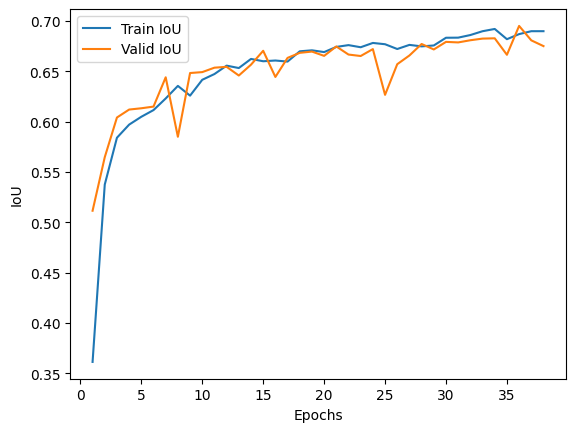


Epoch: 39
valid: 100%|██████████| 34/34 [00:05<00:00,  5.91it/s, cross_entropy_loss - 0.914, iou_score - 0.6824] 

Epoch: 40
valid: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s, cross_entropy_loss - 0.9155, iou_score - 0.6847]


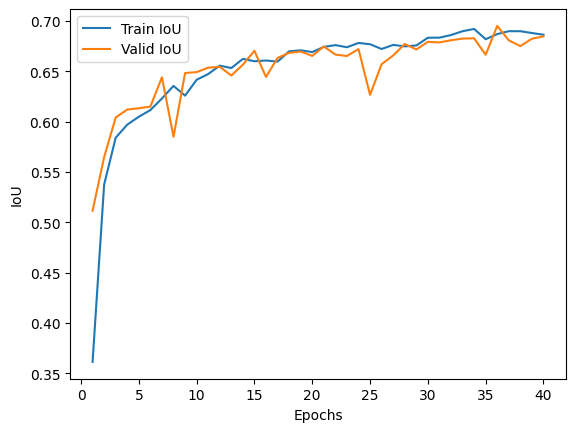


Epoch: 41
valid: 100%|██████████| 34/34 [00:05<00:00,  5.82it/s, cross_entropy_loss - 0.9176, iou_score - 0.686] 

Epoch: 42
valid: 100%|██████████| 34/34 [00:05<00:00,  5.90it/s, cross_entropy_loss - 0.9133, iou_score - 0.6932]


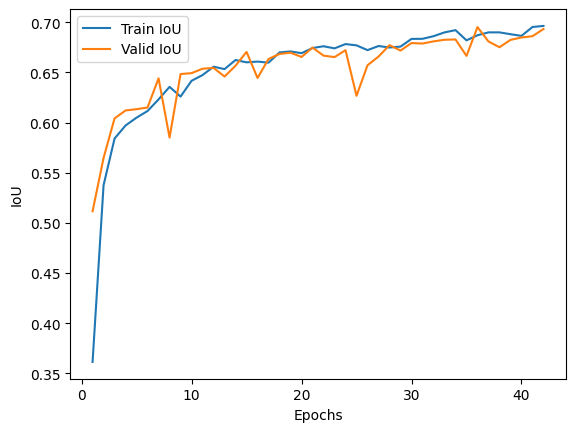


Epoch: 43
valid: 100%|██████████| 34/34 [00:05<00:00,  5.86it/s, cross_entropy_loss - 0.9151, iou_score - 0.6749]

Epoch: 44
valid: 100%|██████████| 34/34 [00:05<00:00,  5.79it/s, cross_entropy_loss - 0.9163, iou_score - 0.6873]


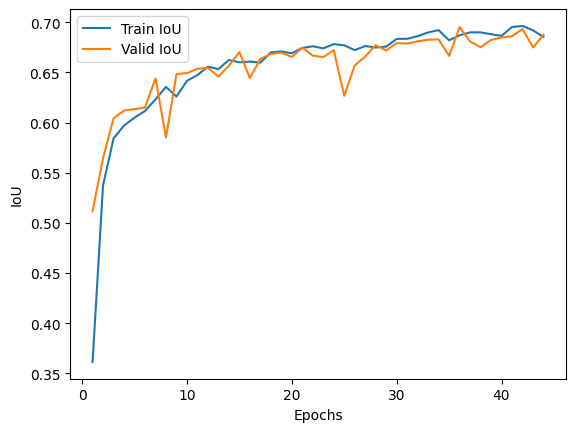


Epoch: 45
valid: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s, cross_entropy_loss - 0.917, iou_score - 0.6922] 

Epoch: 46
valid: 100%|██████████| 34/34 [00:05<00:00,  5.94it/s, cross_entropy_loss - 0.9186, iou_score - 0.673] 


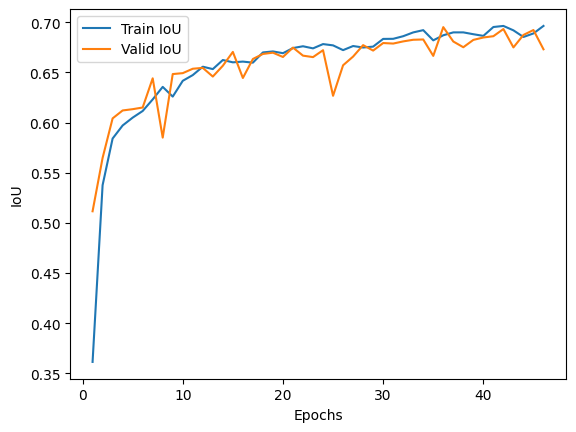


Epoch: 47
valid: 100%|██████████| 34/34 [00:05<00:00,  5.89it/s, cross_entropy_loss - 0.9119, iou_score - 0.6895]

Epoch: 48
valid: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s, cross_entropy_loss - 0.9127, iou_score - 0.6918]


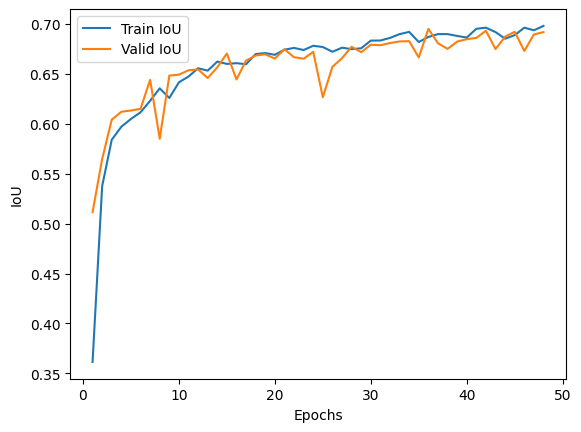


Epoch: 49
valid: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s, cross_entropy_loss - 0.9135, iou_score - 0.6881]

Epoch: 50
valid: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s, cross_entropy_loss - 0.9159, iou_score - 0.7005]
Model saved!


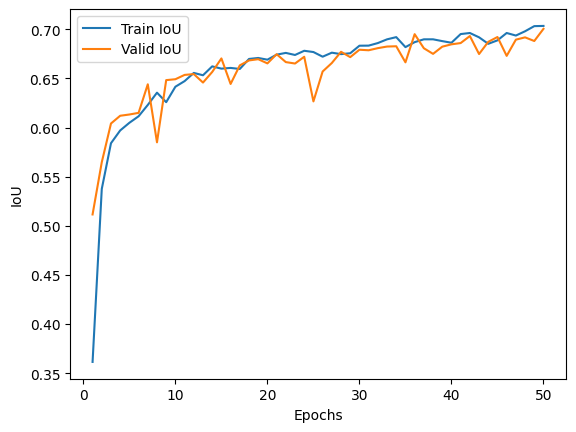


Epoch: 1
valid: 100%|██████████| 34/34 [00:07<00:00,  4.83it/s, cross_entropy_loss - 0.9673, iou_score - 0.5121]
Model saved!

Epoch: 2
valid: 100%|██████████| 34/34 [00:06<00:00,  4.97it/s, cross_entropy_loss - 0.9516, iou_score - 0.5338]
Model saved!


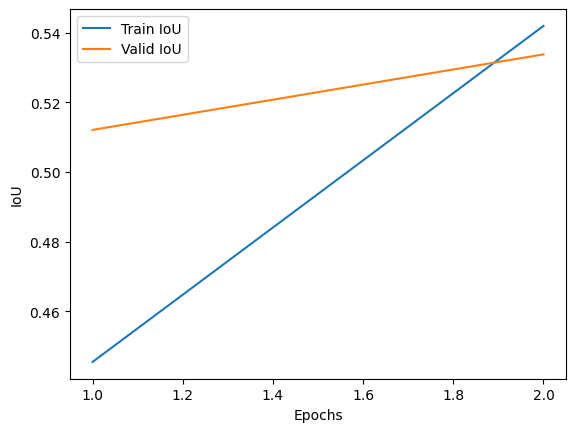


Epoch: 3
valid: 100%|██████████| 34/34 [00:06<00:00,  4.92it/s, cross_entropy_loss - 0.9369, iou_score - 0.5875]
Model saved!

Epoch: 4
valid: 100%|██████████| 34/34 [00:06<00:00,  4.89it/s, cross_entropy_loss - 0.9379, iou_score - 0.5844]


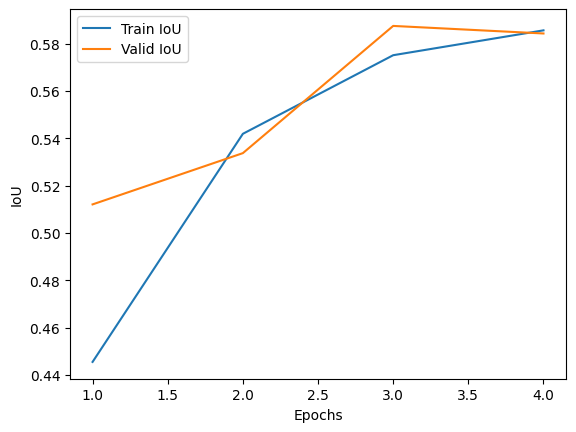


Epoch: 5
valid: 100%|██████████| 34/34 [00:06<00:00,  4.93it/s, cross_entropy_loss - 0.9316, iou_score - 0.5997]
Model saved!

Epoch: 6
valid: 100%|██████████| 34/34 [00:07<00:00,  4.85it/s, cross_entropy_loss - 0.9311, iou_score - 0.5899]


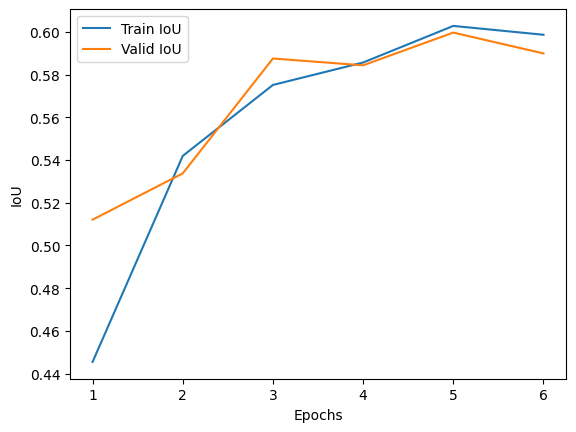


Epoch: 7
valid: 100%|██████████| 34/34 [00:06<00:00,  4.89it/s, cross_entropy_loss - 0.9304, iou_score - 0.5965]

Epoch: 8
valid: 100%|██████████| 34/34 [00:06<00:00,  4.91it/s, cross_entropy_loss - 0.9261, iou_score - 0.6104]
Model saved!


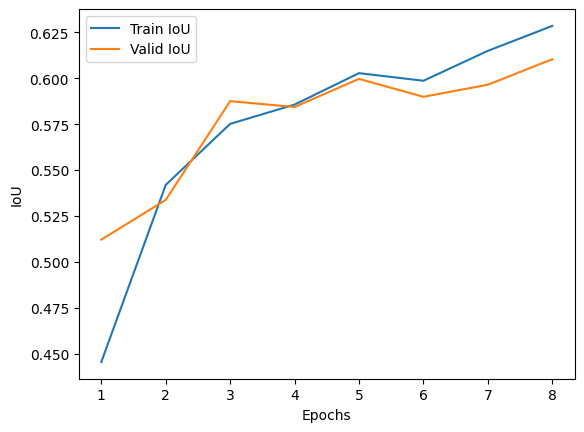


Epoch: 9
valid: 100%|██████████| 34/34 [00:07<00:00,  4.84it/s, cross_entropy_loss - 0.927, iou_score - 0.6231] 
Model saved!

Epoch: 10
valid: 100%|██████████| 34/34 [00:06<00:00,  5.00it/s, cross_entropy_loss - 0.9262, iou_score - 0.6177]


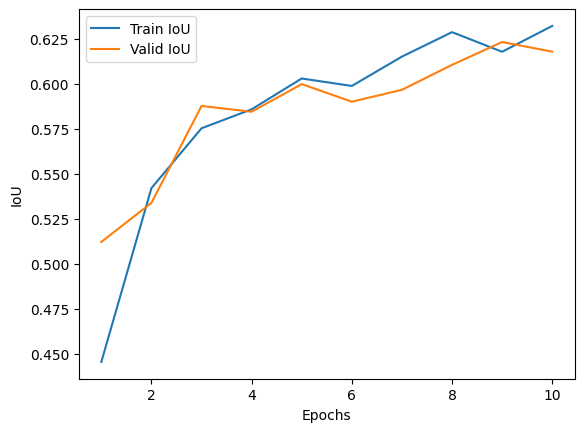


Epoch: 11
valid: 100%|██████████| 34/34 [00:07<00:00,  4.77it/s, cross_entropy_loss - 0.9318, iou_score - 0.6259]
Model saved!

Epoch: 12
valid: 100%|██████████| 34/34 [00:07<00:00,  4.85it/s, cross_entropy_loss - 0.926, iou_score - 0.6259] 


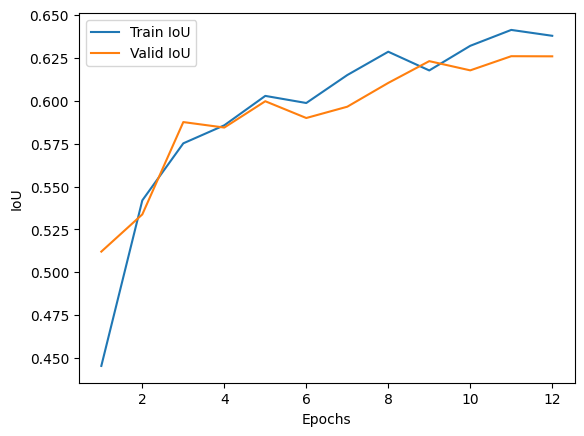


Epoch: 13
valid: 100%|██████████| 34/34 [00:06<00:00,  4.88it/s, cross_entropy_loss - 0.9272, iou_score - 0.6358]
Model saved!

Epoch: 14
valid: 100%|██████████| 34/34 [00:07<00:00,  4.72it/s, cross_entropy_loss - 0.9291, iou_score - 0.6149]


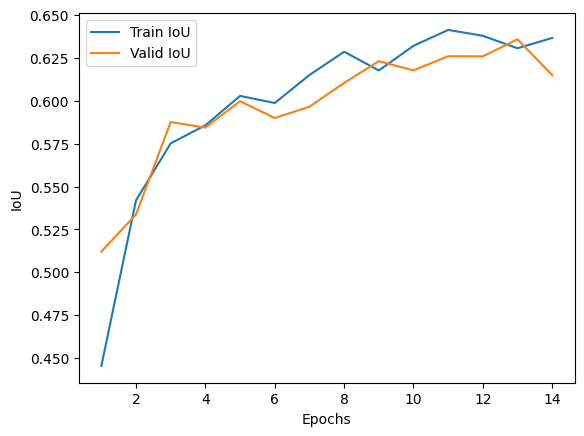


Epoch: 15
valid: 100%|██████████| 34/34 [00:06<00:00,  4.94it/s, cross_entropy_loss - 0.9246, iou_score - 0.6356]

Epoch: 16
valid: 100%|██████████| 34/34 [00:07<00:00,  4.85it/s, cross_entropy_loss - 0.9204, iou_score - 0.6514]
Model saved!


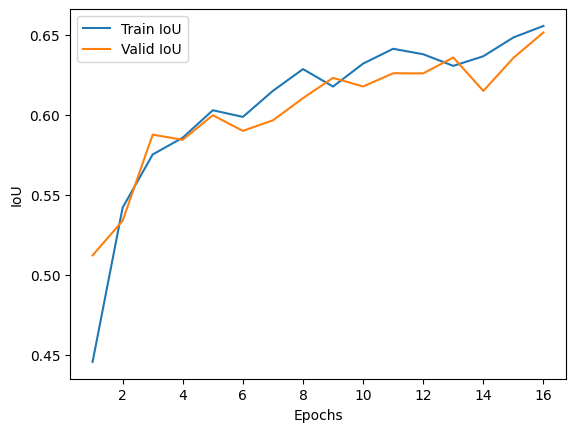


Epoch: 17
valid: 100%|██████████| 34/34 [00:07<00:00,  4.84it/s, cross_entropy_loss - 0.9227, iou_score - 0.649] 

Epoch: 18
valid: 100%|██████████| 34/34 [00:06<00:00,  4.87it/s, cross_entropy_loss - 0.9292, iou_score - 0.6617]
Model saved!


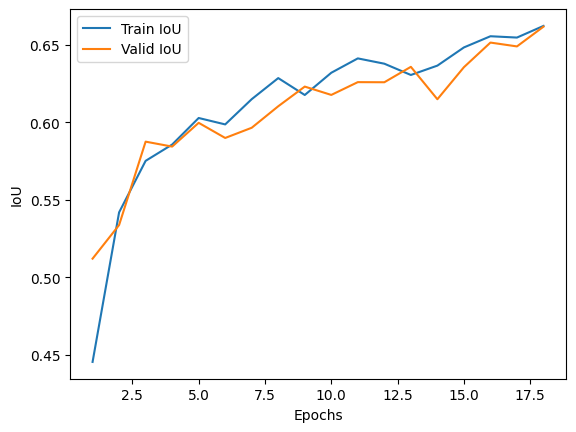


Epoch: 19
valid: 100%|██████████| 34/34 [00:06<00:00,  5.03it/s, cross_entropy_loss - 0.9219, iou_score - 0.6313]

Epoch: 20
valid: 100%|██████████| 34/34 [00:06<00:00,  4.97it/s, cross_entropy_loss - 0.925, iou_score - 0.6437] 


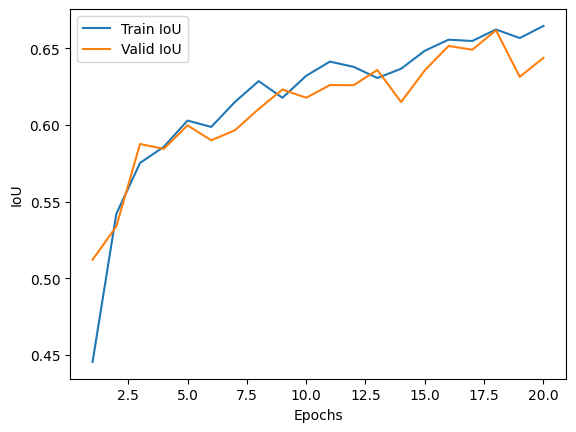


Epoch: 21
valid: 100%|██████████| 34/34 [00:07<00:00,  4.85it/s, cross_entropy_loss - 0.9241, iou_score - 0.6356]

Epoch: 22
valid: 100%|██████████| 34/34 [00:06<00:00,  4.91it/s, cross_entropy_loss - 0.9187, iou_score - 0.6525]


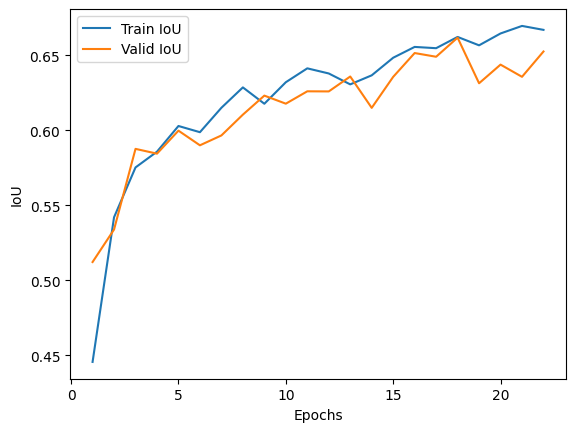


Epoch: 23
valid: 100%|██████████| 34/34 [00:07<00:00,  4.86it/s, cross_entropy_loss - 0.921, iou_score - 0.6606] 

Epoch: 24
valid: 100%|██████████| 34/34 [00:06<00:00,  4.91it/s, cross_entropy_loss - 0.9203, iou_score - 0.6477]


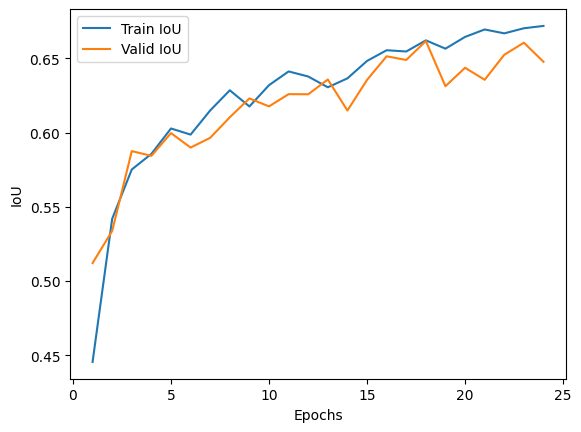


Epoch: 25
valid: 100%|██████████| 34/34 [00:07<00:00,  4.83it/s, cross_entropy_loss - 0.9223, iou_score - 0.6453]

Epoch: 26
valid: 100%|██████████| 34/34 [00:06<00:00,  4.90it/s, cross_entropy_loss - 0.9224, iou_score - 0.6634]
Model saved!


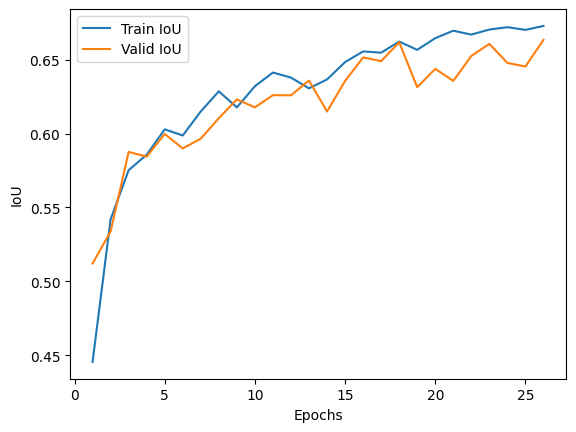


Epoch: 27
valid: 100%|██████████| 34/34 [00:07<00:00,  4.85it/s, cross_entropy_loss - 0.919, iou_score - 0.6698] 
Model saved!

Epoch: 28
valid: 100%|██████████| 34/34 [00:07<00:00,  4.78it/s, cross_entropy_loss - 0.9221, iou_score - 0.6629]


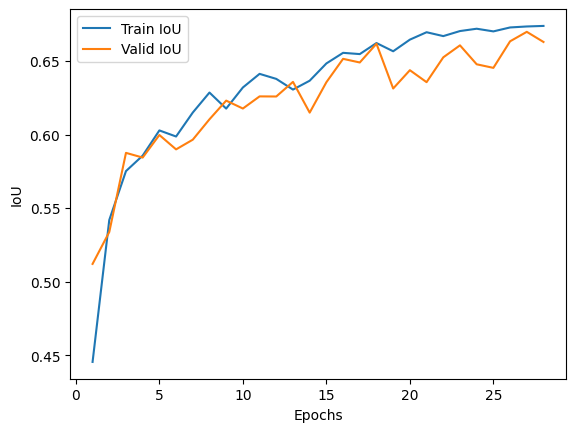


Epoch: 29
valid: 100%|██████████| 34/34 [00:07<00:00,  4.73it/s, cross_entropy_loss - 0.9223, iou_score - 0.6626]

Epoch: 30
valid: 100%|██████████| 34/34 [00:06<00:00,  5.01it/s, cross_entropy_loss - 0.9188, iou_score - 0.6636]


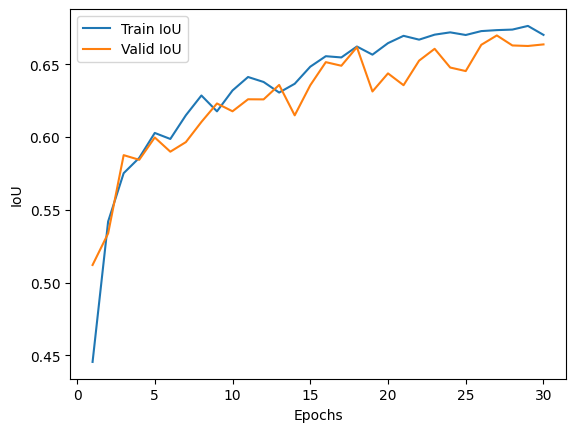


Epoch: 31
valid: 100%|██████████| 34/34 [00:07<00:00,  4.82it/s, cross_entropy_loss - 0.95, iou_score - 0.5635]  

Epoch: 32
valid: 100%|██████████| 34/34 [00:06<00:00,  4.89it/s, cross_entropy_loss - 0.9199, iou_score - 0.6611]


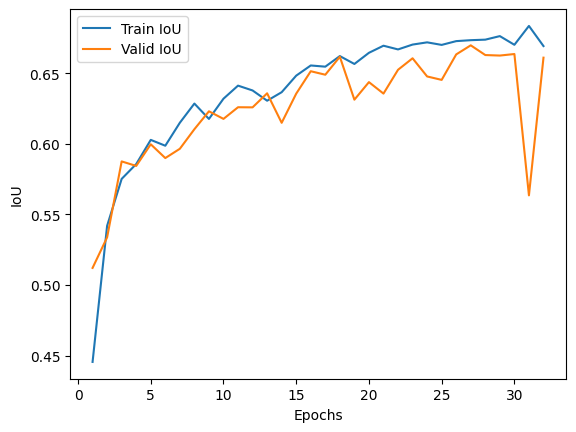


Epoch: 33
valid: 100%|██████████| 34/34 [00:07<00:00,  4.82it/s, cross_entropy_loss - 0.9171, iou_score - 0.6699]
Model saved!

Epoch: 34
valid: 100%|██████████| 34/34 [00:07<00:00,  4.84it/s, cross_entropy_loss - 0.9212, iou_score - 0.6639]


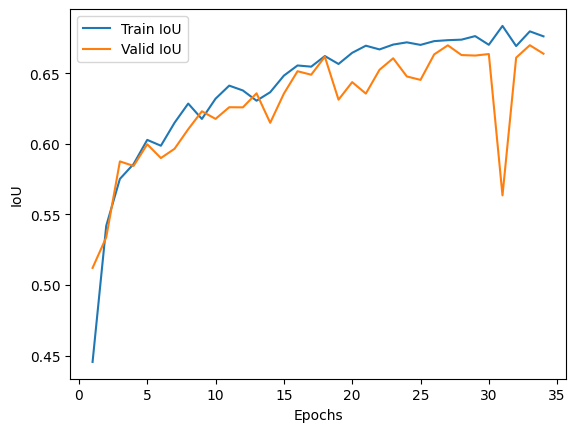


Epoch: 35
valid: 100%|██████████| 34/34 [00:07<00:00,  4.81it/s, cross_entropy_loss - 0.9229, iou_score - 0.6751]
Model saved!

Epoch: 36
valid: 100%|██████████| 34/34 [00:06<00:00,  4.89it/s, cross_entropy_loss - 0.919, iou_score - 0.6698] 


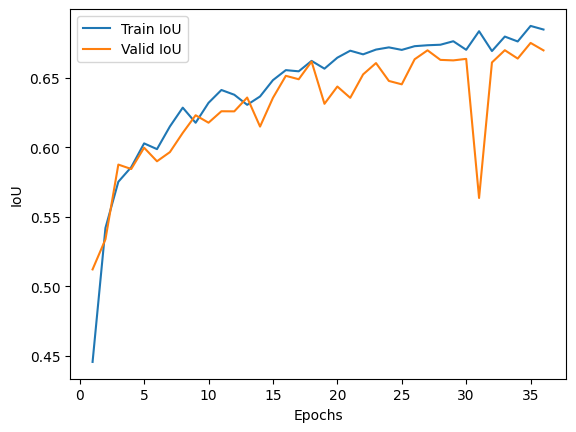


Epoch: 37
valid: 100%|██████████| 34/34 [00:06<00:00,  5.00it/s, cross_entropy_loss - 0.9182, iou_score - 0.669] 

Epoch: 38
valid: 100%|██████████| 34/34 [00:07<00:00,  4.83it/s, cross_entropy_loss - 0.9198, iou_score - 0.6518]


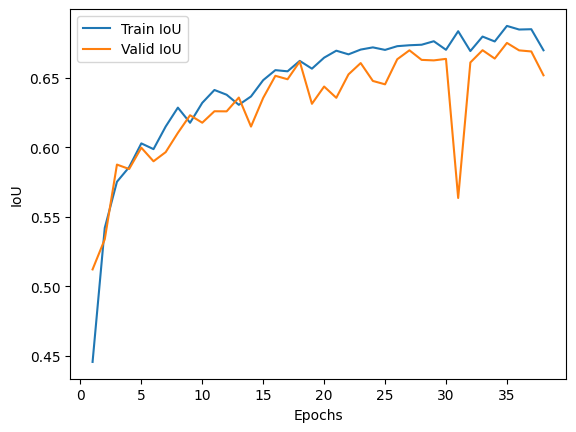


Epoch: 39
valid: 100%|██████████| 34/34 [00:06<00:00,  4.92it/s, cross_entropy_loss - 0.9192, iou_score - 0.6651]

Epoch: 40
valid: 100%|██████████| 34/34 [00:06<00:00,  4.97it/s, cross_entropy_loss - 0.918, iou_score - 0.6785] 
Model saved!


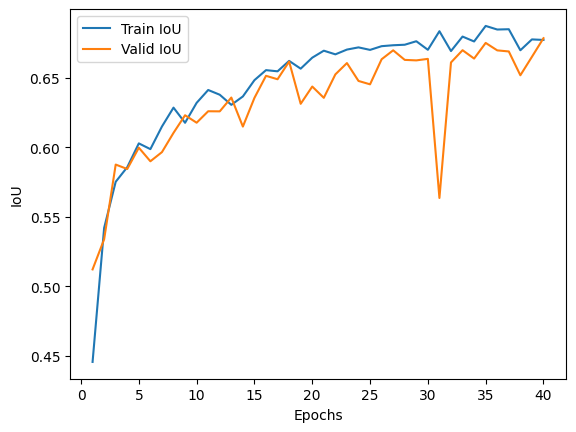


Epoch: 41
valid: 100%|██████████| 34/34 [00:06<00:00,  4.88it/s, cross_entropy_loss - 0.9173, iou_score - 0.6752]

Epoch: 42
valid: 100%|██████████| 34/34 [00:07<00:00,  4.79it/s, cross_entropy_loss - 0.9158, iou_score - 0.6786]
Model saved!


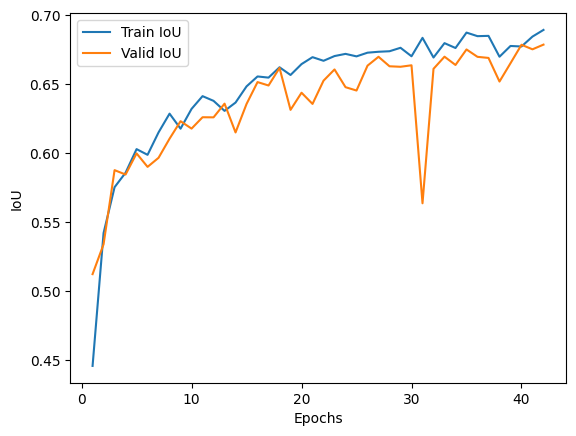


Epoch: 43
valid: 100%|██████████| 34/34 [00:06<00:00,  4.89it/s, cross_entropy_loss - 0.9196, iou_score - 0.6797]
Model saved!

Epoch: 44
valid: 100%|██████████| 34/34 [00:06<00:00,  4.90it/s, cross_entropy_loss - 0.915, iou_score - 0.6837] 
Model saved!


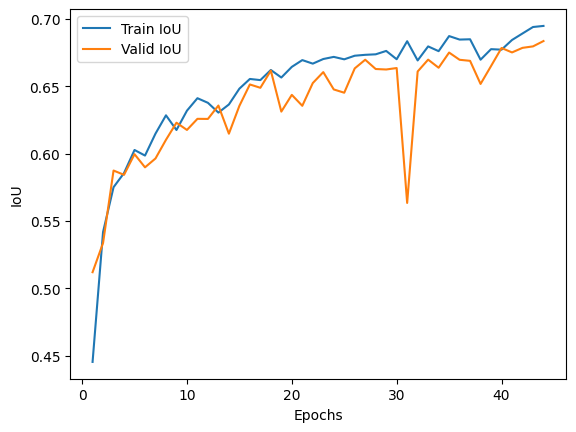


Epoch: 45
valid: 100%|██████████| 34/34 [00:07<00:00,  4.82it/s, cross_entropy_loss - 0.9185, iou_score - 0.6787]

Epoch: 46
valid: 100%|██████████| 34/34 [00:06<00:00,  4.95it/s, cross_entropy_loss - 0.9187, iou_score - 0.6785]


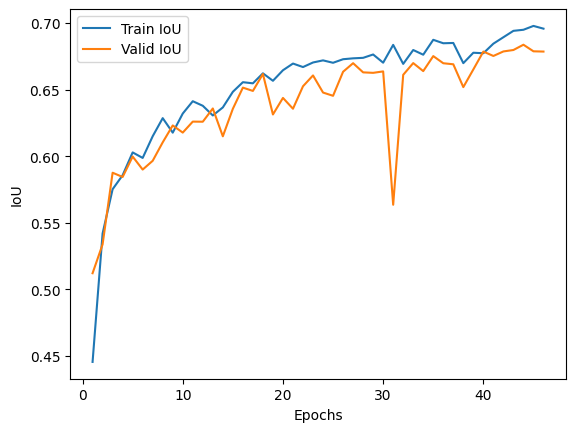


Epoch: 47
valid: 100%|██████████| 34/34 [00:07<00:00,  4.80it/s, cross_entropy_loss - 0.9145, iou_score - 0.6785]

Epoch: 48
valid: 100%|██████████| 34/34 [00:07<00:00,  4.84it/s, cross_entropy_loss - 0.9153, iou_score - 0.6728]


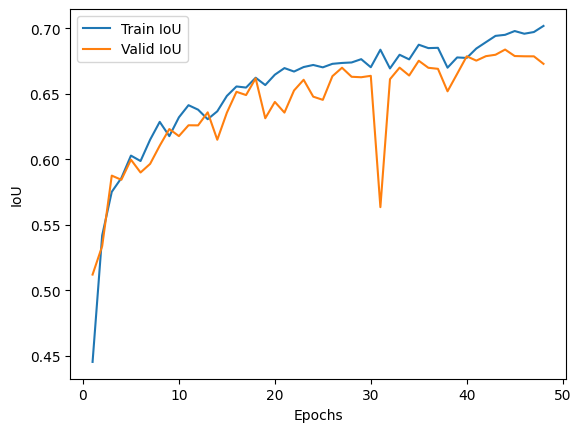


Epoch: 49
valid: 100%|██████████| 34/34 [00:07<00:00,  4.82it/s, cross_entropy_loss - 0.915, iou_score - 0.6832] 

Epoch: 50
valid: 100%|██████████| 34/34 [00:06<00:00,  4.88it/s, cross_entropy_loss - 0.917, iou_score - 0.6841] 
Model saved!


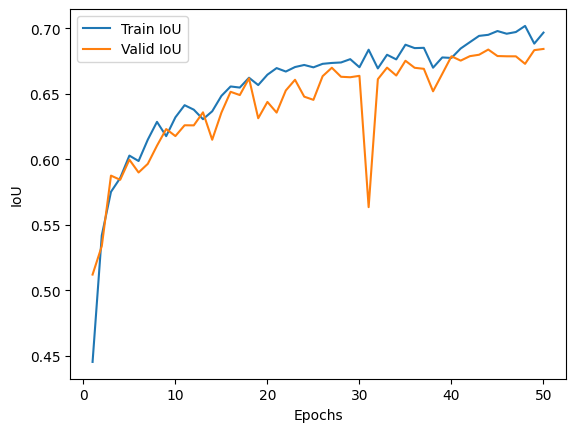

In [13]:
train_model(unet, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/mixed/unet.pth", 50)
train_model(fcn, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/mixed/fcn.pth", 50)
train_model(mobile, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/mixed/mobile.pth", 50)
train_model(deeplab, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/mixed/deeplab.pth", 50)

### Load and view model predictions

In [14]:
model = torch.load("/content/drive/MyDrive/FRESH/mix/unet.pth", map_location=DEVICE)
view_predictions(model,val_ds, num_classes)

model = torch.load("/content/drive/MyDrive/FRESH/mix/fcn.pth", map_location=DEVICE)
view_predictions(model,val_ds, num_classes)

model = torch.load("/content/drive/MyDrive/FRESH/mix/mobile.pth", map_location=DEVICE)
view_predictions(model,val_ds, num_classes)

model = torch.load("/content/drive/MyDrive/FRESH/mix/deeplab.pth", map_location=DEVICE)
view_predictions(model,val_ds, num_classes)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/FRESH/mix/unet.pth'

# label adapter

In [ ]:
xs, ys = save_predictions(model, train_ds)

saving 0 / 1600
saving 1 / 1600
saving 2 / 1600
saving 3 / 1600
saving 4 / 1600
saving 5 / 1600
saving 6 / 1600
saving 7 / 1600
saving 8 / 1600
saving 9 / 1600
saving 10 / 1600
saving 11 / 1600
saving 12 / 1600
saving 13 / 1600
saving 14 / 1600
saving 15 / 1600
saving 16 / 1600
saving 17 / 1600
saving 18 / 1600
saving 19 / 1600
saving 20 / 1600
saving 21 / 1600
saving 22 / 1600
saving 23 / 1600
saving 24 / 1600
saving 25 / 1600
saving 26 / 1600
saving 27 / 1600
saving 28 / 1600
saving 29 / 1600
saving 30 / 1600
saving 31 / 1600
saving 32 / 1600
saving 33 / 1600
saving 34 / 1600
saving 35 / 1600
saving 36 / 1600
saving 37 / 1600
saving 38 / 1600
saving 39 / 1600
saving 40 / 1600
saving 41 / 1600
saving 42 / 1600
saving 43 / 1600
saving 44 / 1600
saving 45 / 1600
saving 46 / 1600
saving 47 / 1600
saving 48 / 1600
saving 49 / 1600
saving 50 / 1600
saving 51 / 1600
saving 52 / 1600
saving 53 / 1600
saving 54 / 1600
saving 55 / 1600
saving 56 / 1600
saving 57 / 1600
saving 58 / 1600
saving 

In [ ]:
len(xs)

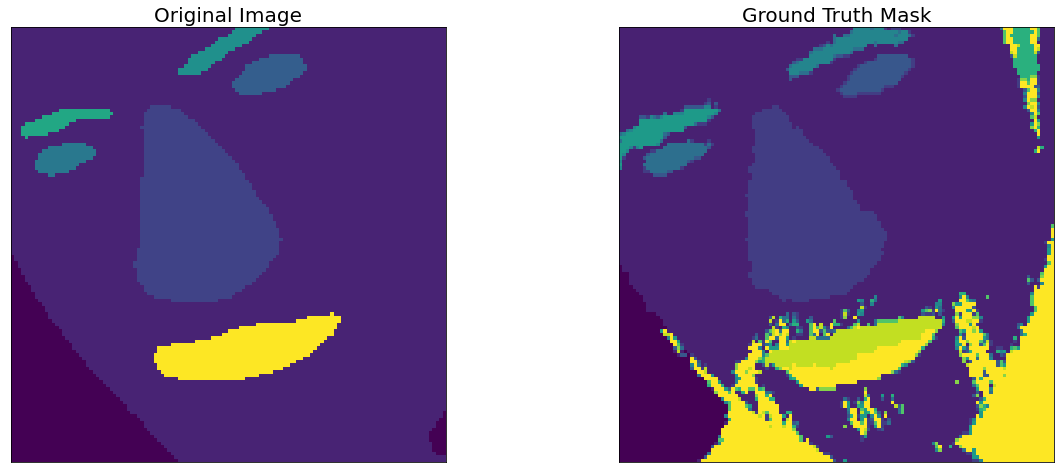

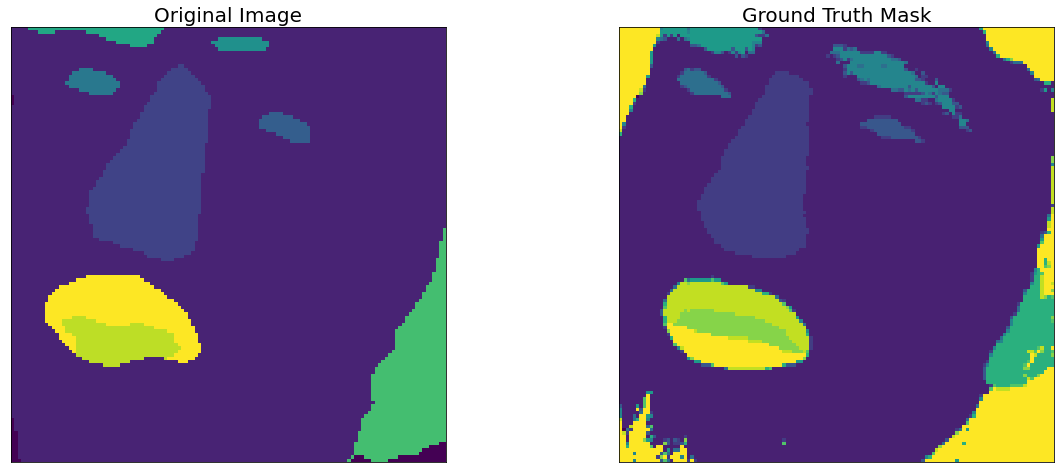

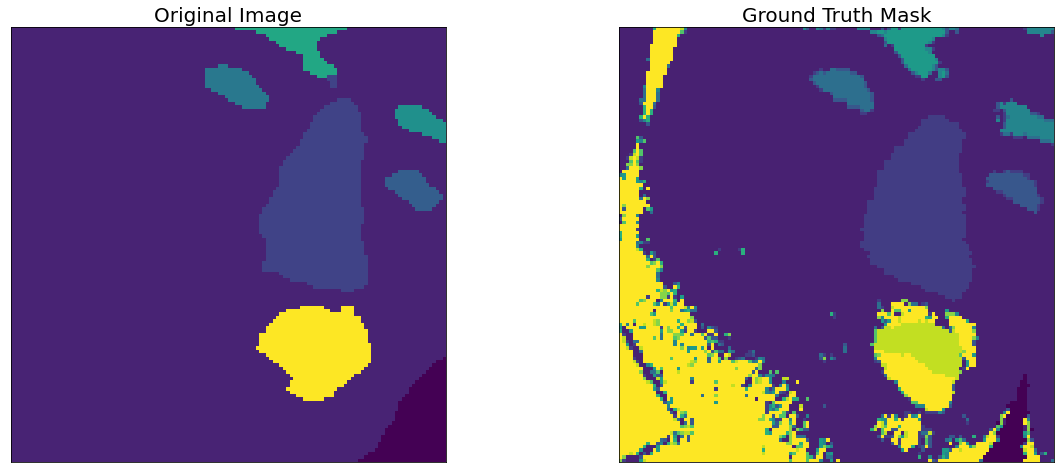

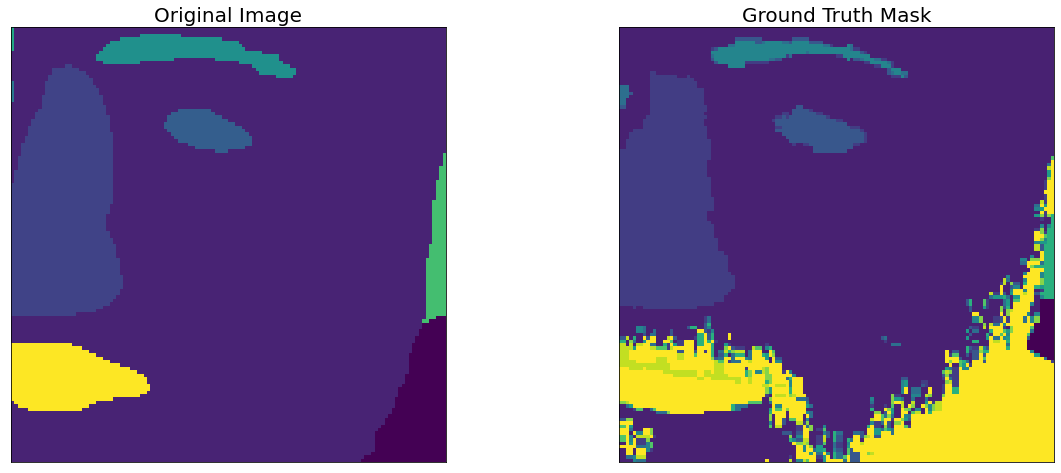

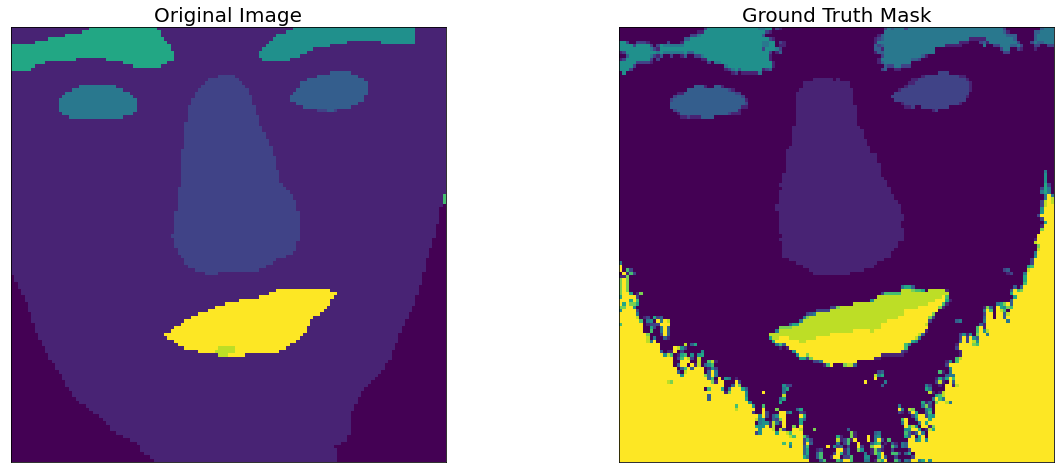

In [ ]:
for x in range(5):
  visualize(
      original_image = colour_code_segmentation(reverse_one_hot(xs[x]), rgb_vals),
      ground_truth_mask = colour_code_segmentation(reverse_one_hot(ys[x]), rgb_vals),
      #ground_truth_mask = colour_code_segmentation(reverse_one_hot(ys[x]), rgb_vals)
  )


In [ ]:
X2 = torch.stack(xs)
Y2 = torch.stack(ys)
print(X2.shape)
print(Y2.shape)

torch.Size([1600, 12, 128, 128])
torch.Size([1600, 12, 128, 128])


In [ ]:
Y2 = Y2.float()
X2 = X2.float()
Y2.dtype

torch.float32

In [ ]:
from sklearn.model_selection import train_test_split
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size=0.2, shuffle=True)

print(x_train2.shape)
print(y_train2.shape)


#X = X.numpy().reindex(np.random.permutation(X.index))
#one_hot_Y = one_hot_Y.numpy().reindex(np.random.permutation(one_hot_Y.index))

torch.Size([1280, 12, 128, 128])
torch.Size([1280, 12, 128, 128])


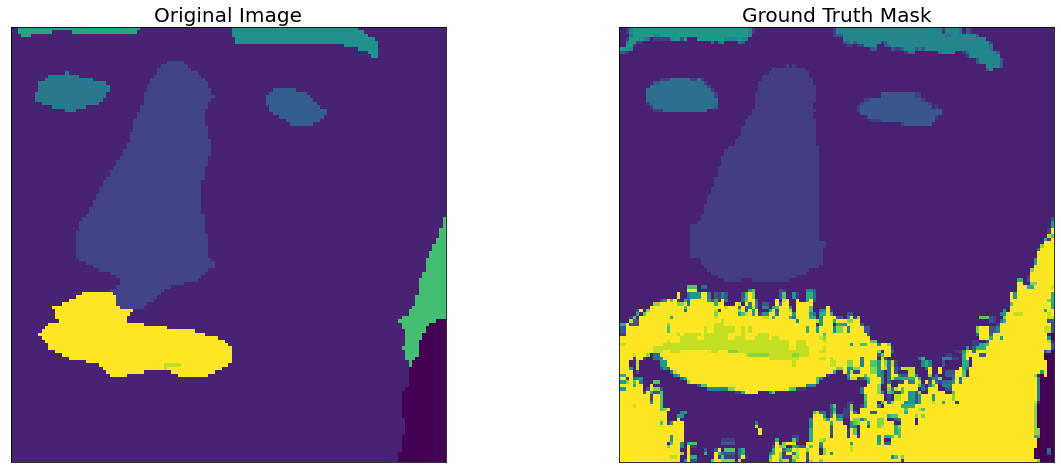

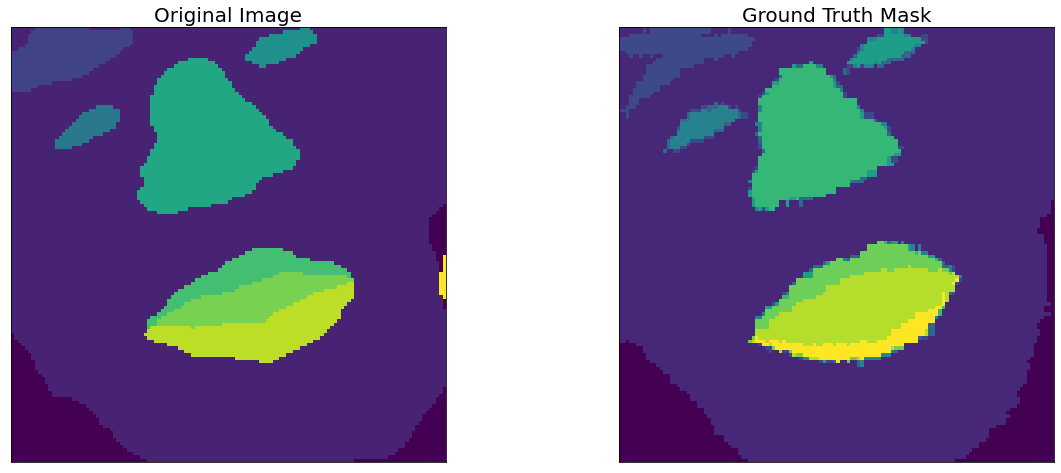

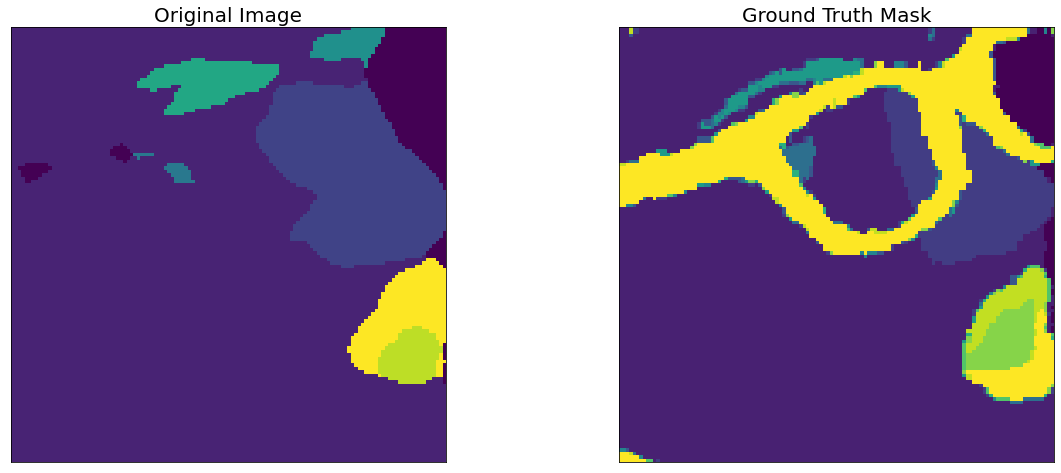

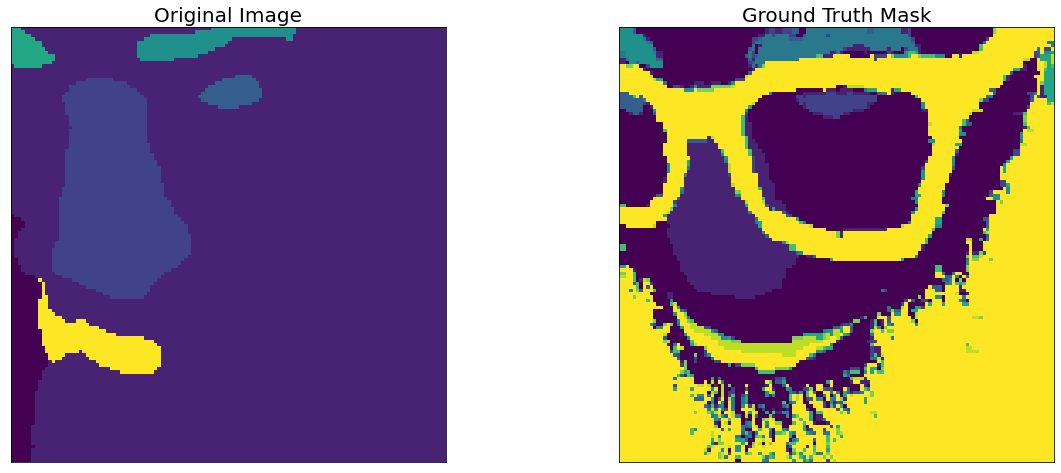

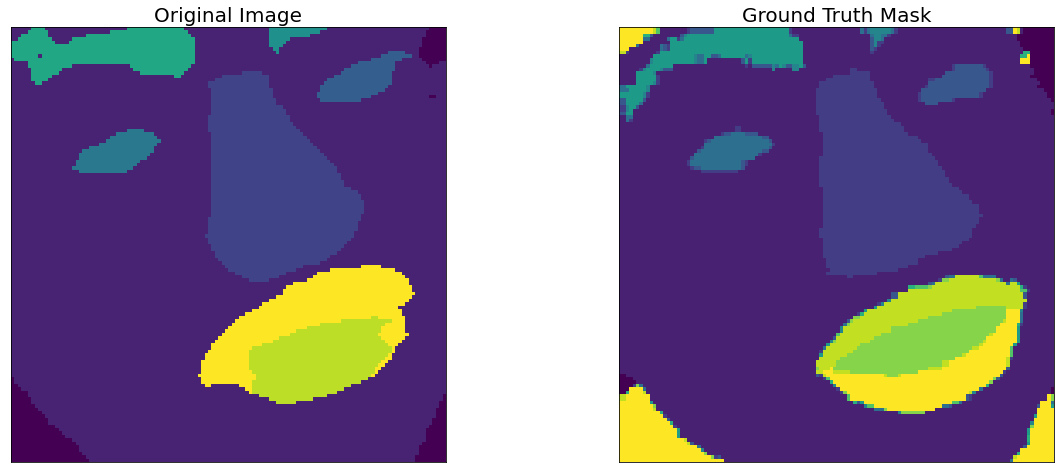

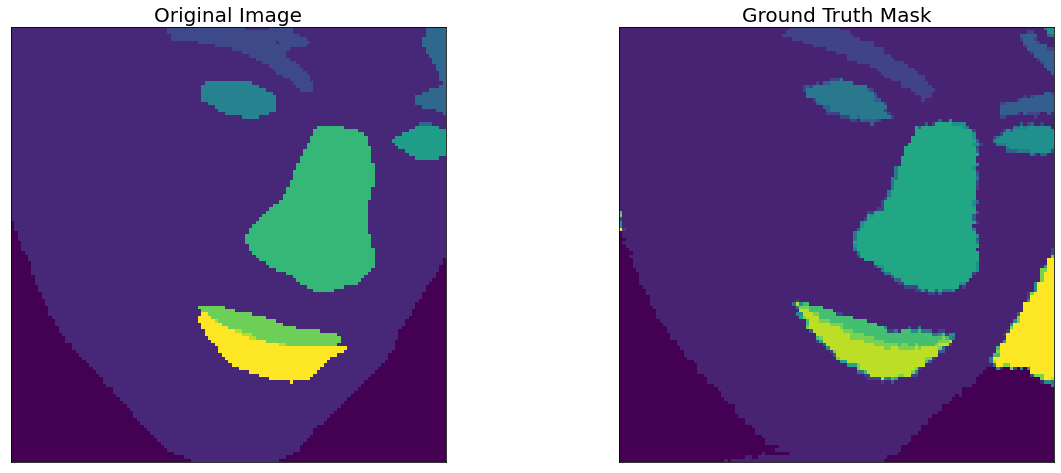

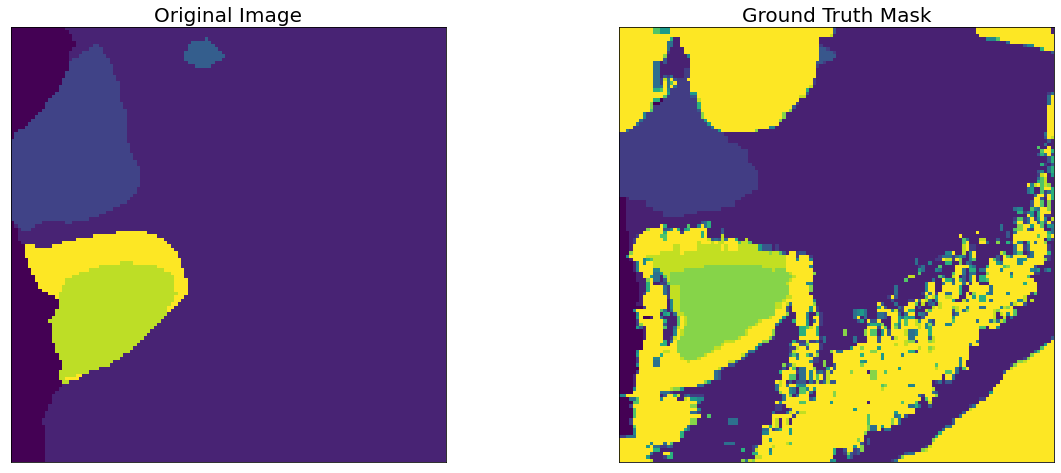

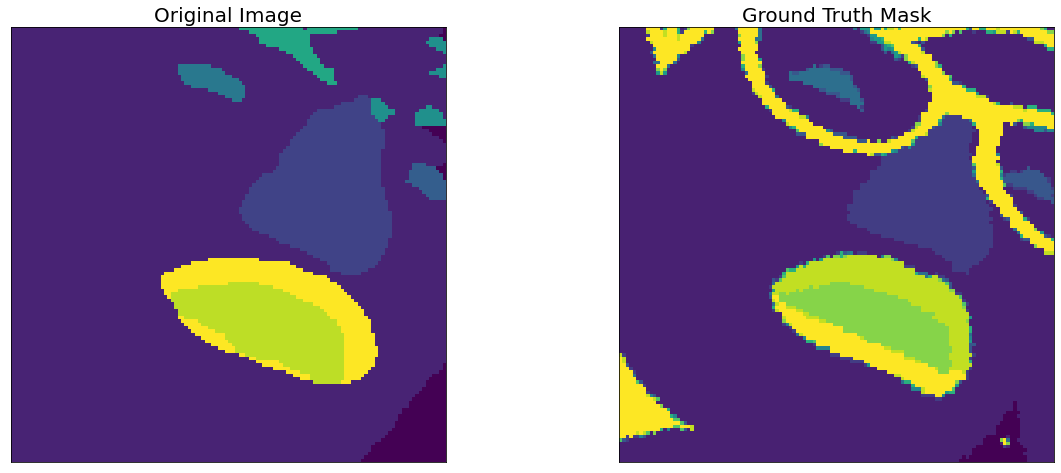

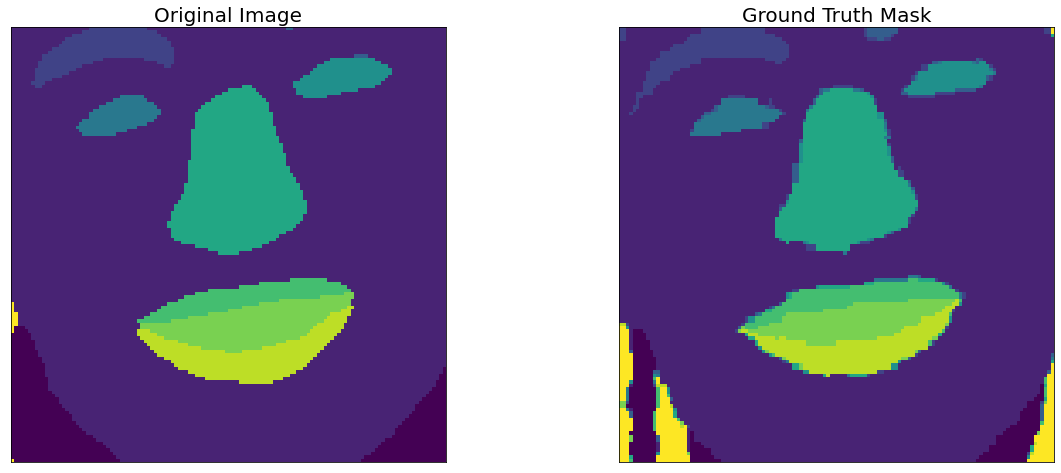

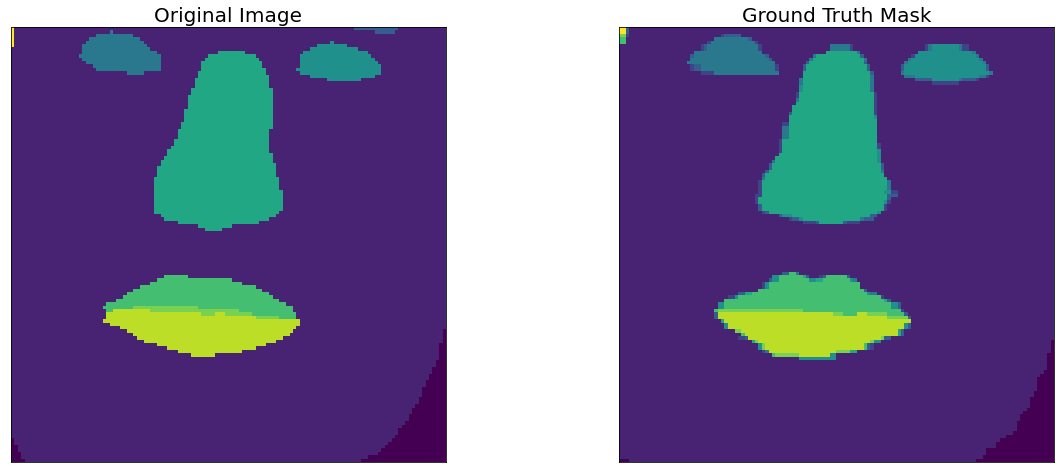

In [ ]:
for x in range(10):
  visualize(
      original_image =  reverse_one_hot(x_train2[x]),
      ground_truth_mask = reverse_one_hot(y_train2[x]),
      #one_hot_encoded_mask = reverse_one_hot(y_test[x])
  )


## create our datasets

In [ ]:
import torchvision.transforms as T
import torchvision.transforms.functional as F
import random

class MyDataSet(torch.utils.data.Dataset):
  def __init__(self, x, y):
    super(MyDataSet, self).__init__()
    
    # store the augmented tensors tensors
    self._x, self._y = x,y

  def __len__(self):
    # a DataSet must know it size
    return self._x.shape[0]

  def __getitem__(self, index):
    x = torch.tensor(np.expand_dims(colour_code_segmentation(reverse_one_hot(torch.tensor(self._x[index, :])), rgb_vals),0).astype(float)).to(device="cuda", dtype=torch.float)
    y = self._y[index, :]
    # print("GETTING ITEM")
    return x, y

train_ds2 = MyDataSet(x_train2, y_train2)
val_ds2 = MyDataSet(x_test2, y_test2)


### Data Loader

In [ ]:
from torch.utils.data import DataLoader

# Get train and val data loaders
train_loader2 = DataLoader(train_ds2, batch_size=64, shuffle=True)
valid_loader2 = DataLoader(val_ds2, batch_size=20, shuffle=False)

In [ ]:
print(len(train_loader2))

20


In [ ]:
label_adapter = smp.Unet(
    in_channels=1,
    encoder_name=ENCODER, 
    encoder_weights="imagenet", 
    classes=num_classes, 
    activation=ACTIVATION,
    #encoder_depth = 18,
    #decoder_channels = 18,
    decoder_use_batchnorm = True,
    #aux_params=aux_params
)
#preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


Epoch: 1
train:   0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-37-1d7294a8c16e>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(np.expand_dims(colour_code_segmentation(reverse_one_hot(torch.tensor(self._x[index, :])), rgb_vals),0).astype(float)).to(device="cuda", dtype=torch.float)


valid: 100%|██████████| 16/16 [00:00<00:00, 20.00it/s, cross_entropy_loss - 1.057, iou_score - 0.3915]
Model saved!

Epoch: 2
valid: 100%|██████████| 16/16 [00:00<00:00, 20.08it/s, cross_entropy_loss - 0.9646, iou_score - 0.5273]
Model saved!


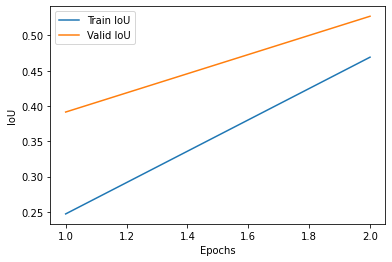


Epoch: 3
valid: 100%|██████████| 16/16 [00:00<00:00, 21.11it/s, cross_entropy_loss - 0.9322, iou_score - 0.5652]
Model saved!

Epoch: 4
valid: 100%|██████████| 16/16 [00:00<00:00, 20.94it/s, cross_entropy_loss - 0.9271, iou_score - 0.6156]
Model saved!


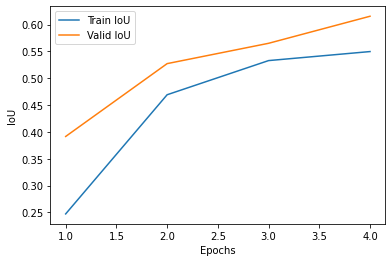


Epoch: 5
valid: 100%|██████████| 16/16 [00:00<00:00, 19.77it/s, cross_entropy_loss - 0.9085, iou_score - 0.6434]
Model saved!

Epoch: 6
valid: 100%|██████████| 16/16 [00:00<00:00, 21.15it/s, cross_entropy_loss - 0.9024, iou_score - 0.6423]


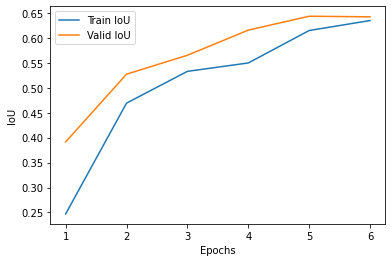


Epoch: 7
valid: 100%|██████████| 16/16 [00:00<00:00, 19.26it/s, cross_entropy_loss - 0.8905, iou_score - 0.6808]
Model saved!

Epoch: 8
valid: 100%|██████████| 16/16 [00:00<00:00, 20.67it/s, cross_entropy_loss - 0.8867, iou_score - 0.6878]
Model saved!


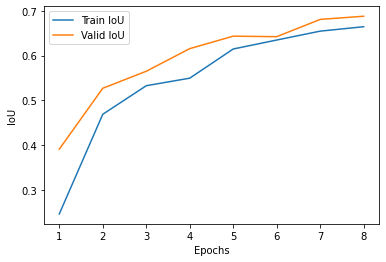


Epoch: 9
valid: 100%|██████████| 16/16 [00:00<00:00, 20.96it/s, cross_entropy_loss - 0.8851, iou_score - 0.6971]
Model saved!

Epoch: 10
valid: 100%|██████████| 16/16 [00:00<00:00, 20.87it/s, cross_entropy_loss - 0.8809, iou_score - 0.6958]


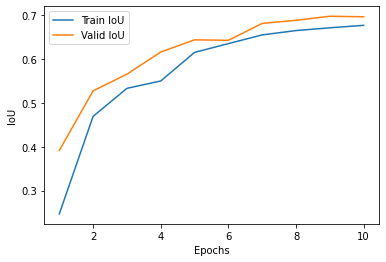


Epoch: 11
valid: 100%|██████████| 16/16 [00:00<00:00, 19.73it/s, cross_entropy_loss - 0.8801, iou_score - 0.6961]

Epoch: 12
valid: 100%|██████████| 16/16 [00:00<00:00, 19.83it/s, cross_entropy_loss - 0.8786, iou_score - 0.6964]


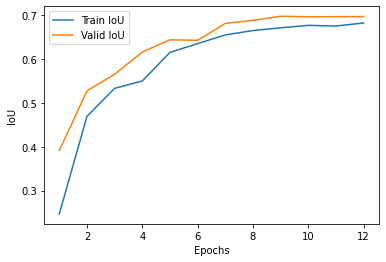


Epoch: 13
valid: 100%|██████████| 16/16 [00:00<00:00, 21.45it/s, cross_entropy_loss - 0.8776, iou_score - 0.7003]
Model saved!

Epoch: 14
valid: 100%|██████████| 16/16 [00:00<00:00, 21.18it/s, cross_entropy_loss - 0.8768, iou_score - 0.6991]


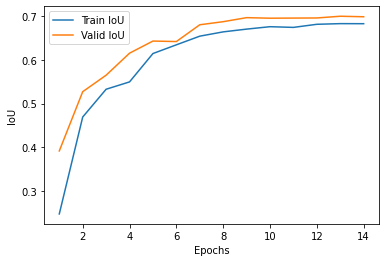


Epoch: 15
valid: 100%|██████████| 16/16 [00:00<00:00, 19.52it/s, cross_entropy_loss - 0.8762, iou_score - 0.7036]
Model saved!

Epoch: 16
valid: 100%|██████████| 16/16 [00:00<00:00, 19.94it/s, cross_entropy_loss - 0.8752, iou_score - 0.697]


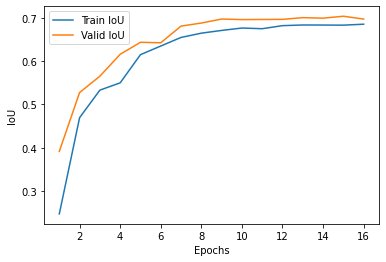


Epoch: 17
valid: 100%|██████████| 16/16 [00:00<00:00, 21.10it/s, cross_entropy_loss - 0.877, iou_score - 0.6997]

Epoch: 18
valid: 100%|██████████| 16/16 [00:00<00:00, 19.39it/s, cross_entropy_loss - 0.8742, iou_score - 0.6993]


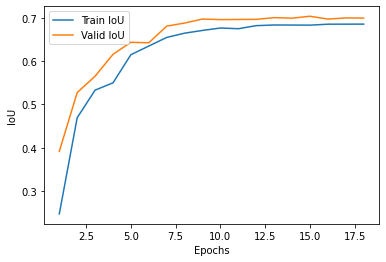


Epoch: 19
valid: 100%|██████████| 16/16 [00:00<00:00, 21.29it/s, cross_entropy_loss - 0.8785, iou_score - 0.6949]

Epoch: 20
train:   5%|▌         | 1/20 [00:00<00:04,  4.28it/s, cross_entropy_loss - 0.8619, iou_score - 0.6689]


KeyboardInterrupt: ignored

In [ ]:
train_model(label_adapter, train_loader2, valid_loader2, "/content/drive/MyDrive/FRESH/label_adapter.pth", 100)

### Load and view model predictions

In [ ]:
from sklearn.metrics import jaccard_score, f1_score
import tensorflow as tf
from torchmetrics.classification import F1Score, BinaryF1Score, MulticlassF1Score, JaccardIndex
from torchmetrics import Dice
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision.utils import save_image
from PIL import Image

def average(lst):
    return sum(lst) / len(lst)

def view_label_predictions(model, ds, numm_classes ):

    ious = []
    f1s = []

    #predict
    for idx in range(len(ds)):

        image, gt_mask = ds[idx]
        image = image.cpu()
        image_vis = image.cpu()
        image_vis = np.transpose(image_vis,(1,2,0))
        #print("vis:",image_vis.shape)
        #print("im:",image.shape)
        
        x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
        #print("X_TENSOR:", x_tensor, x_tensor.shape)
        # Predict test image
        pred_mask = model(x_tensor)
        #print("predraw", pred_mask.shape)
        #print("gtraw", gt_mask.shape)
        pred_mask = pred_mask.detach().squeeze().cpu().numpy()
        # Convert pred_mask from `CHW` format to `HWC` format
        #print(pred_mask.shape)
        # Get prediction channel corresponding to face
        pred_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(pred_mask)), rgb_vals)
        #print(pred_mask.shape)
        
        # Convert gt_mask from `CHW` format to `HWC` format
        #print(gt_mask.shape)
        gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
        
        #get IoU score
        m = tf.keras.metrics.MeanIoU(num_classes=numm_classes)
        m.update_state(gt_mask, pred_mask)
        iou = m.result().numpy()
        #print("MEAN IoU:" , iou)
        ious.append(iou)

        #gt_mask = scipy.signal.medfilt(gt_mask, 9)

        #Get f1
        #m = MultiLabelBinarizer().fit(gt_mask)
        #f1 = f1_score(m.transform(gt_mask), m.transform(pred_mask), average=None)
        #if len(f1) == num_classes:
        #  f1s.append(f1)

        metric = MulticlassF1Score(num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        #metric = JaccardIndex(task="multiclass",num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        f1 = metric(torch.tensor(pred_mask), torch.tensor(gt_mask))
        if len(f1) == num_classes:
          f1[f1 <0.1] = np.nan()
          #print(f1)
          f1s.append(np.array(f1))

        try:
          if idx < 20:
            visualize(
                original_image = image[0,::],
                ground_truth_mask = gt_mask,
                predicted_mask = pred_mask,
            )
        except:
          if idx < 20:
            visualize(
                original_image = image.cuda()[0,::],
                ground_truth_mask = gt_mask.cuda(),
                predicted_mask = pred_mask.cuda(),
            )

    
    fs1_numpy = np.array(f1s)
    av_f1s = np.nanmean(fs1_numpy, axis=0)
    #av_f1s = fs1_numpy.mean(axis=0)
    av_f1s_av = av_f1s.mean(axis=0)

    print ("Dataset MIoU = ", average(ious))
    print ("Dataset F1 = ", av_f1s)
    print ("Dataset F1 av = ", av_f1s_av)

<ipython-input-37-1d7294a8c16e>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(np.expand_dims(colour_code_segmentation(reverse_one_hot(torch.tensor(self._x[index, :])), rgb_vals),0).astype(float)).to(device="cuda", dtype=torch.float)
<ipython-input-45-668078d6a306>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
<ipython-input-45-668078d6a306>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask

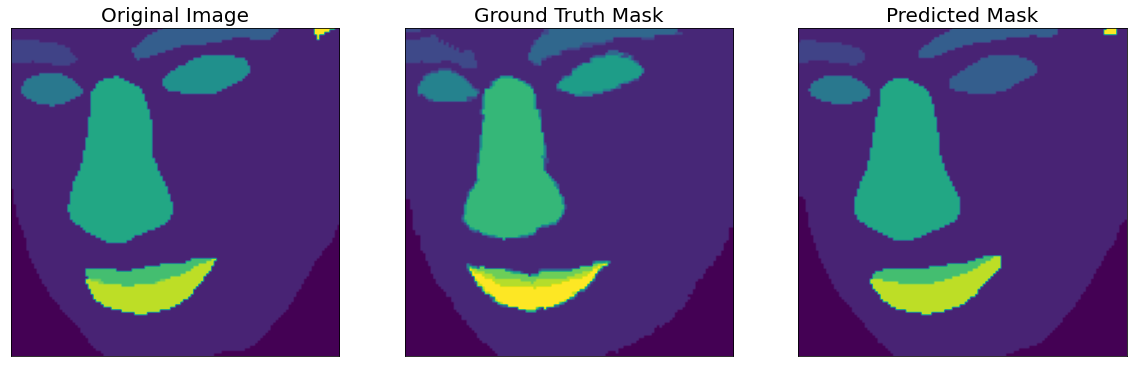

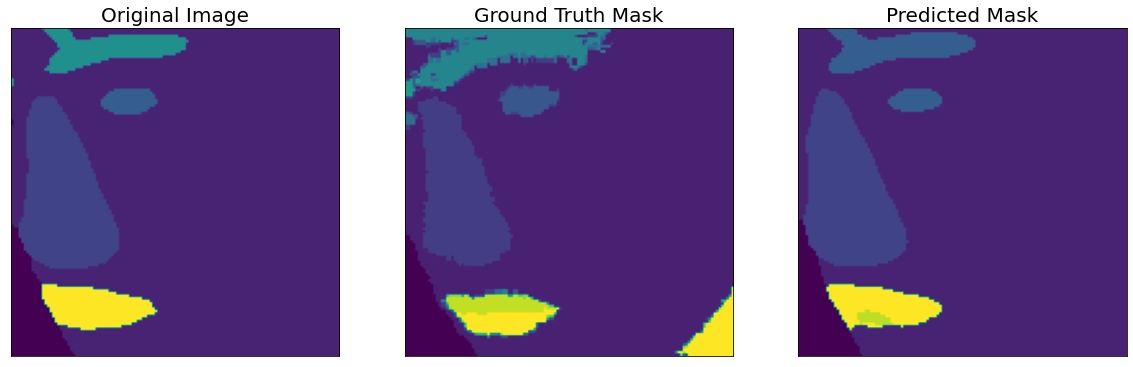

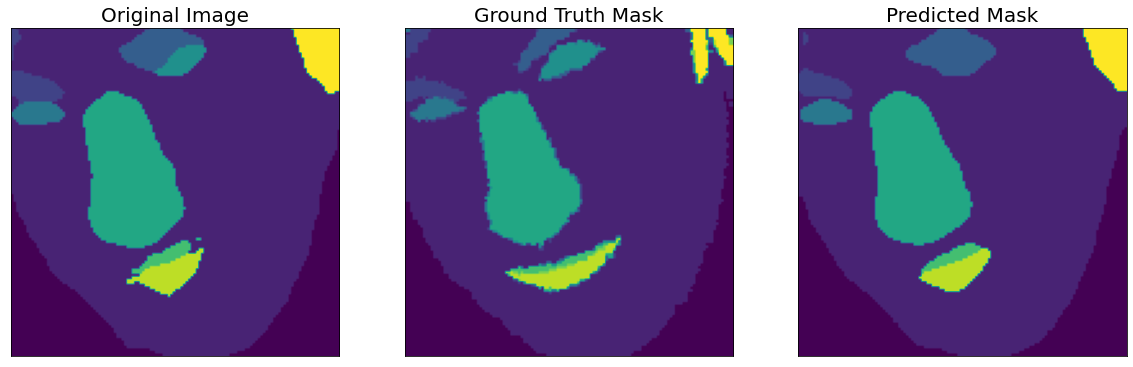

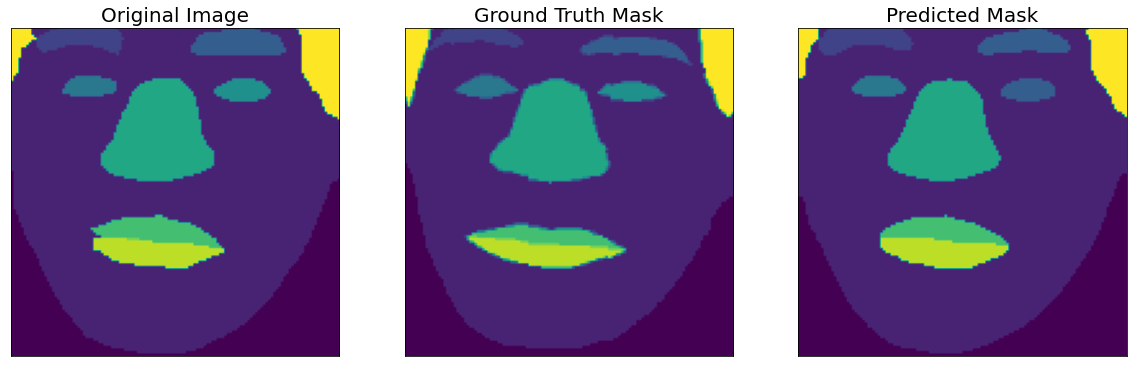

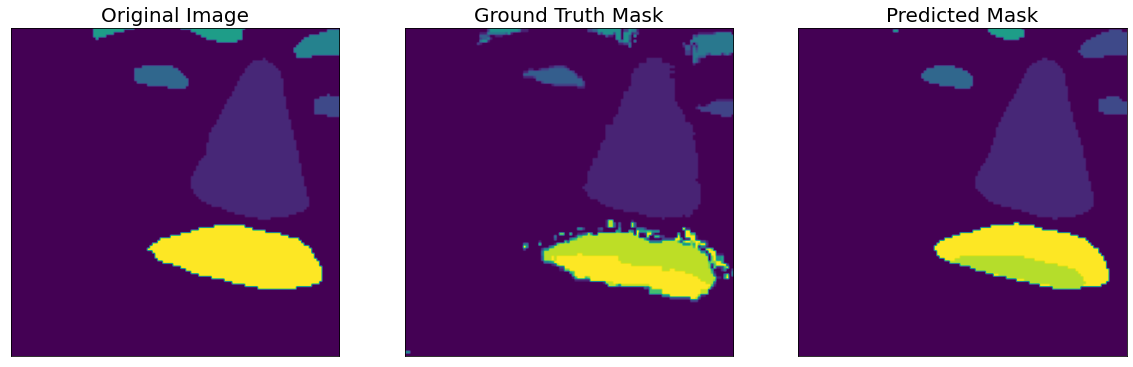

Exception ignored in: <function _ConnectionBase.__del__ at 0x7fa36d2ce5e0>
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


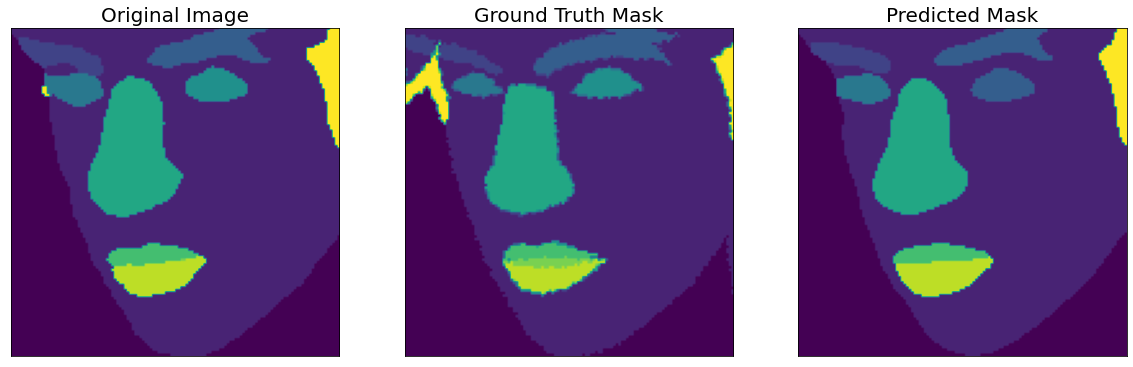

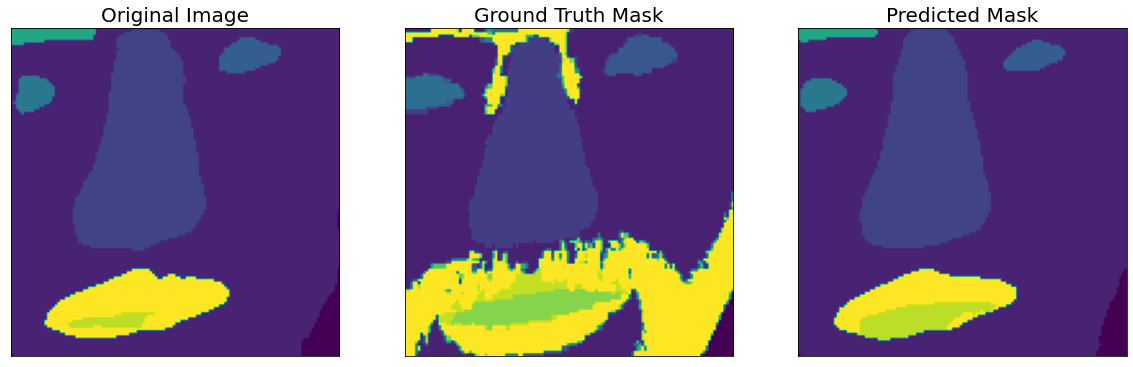

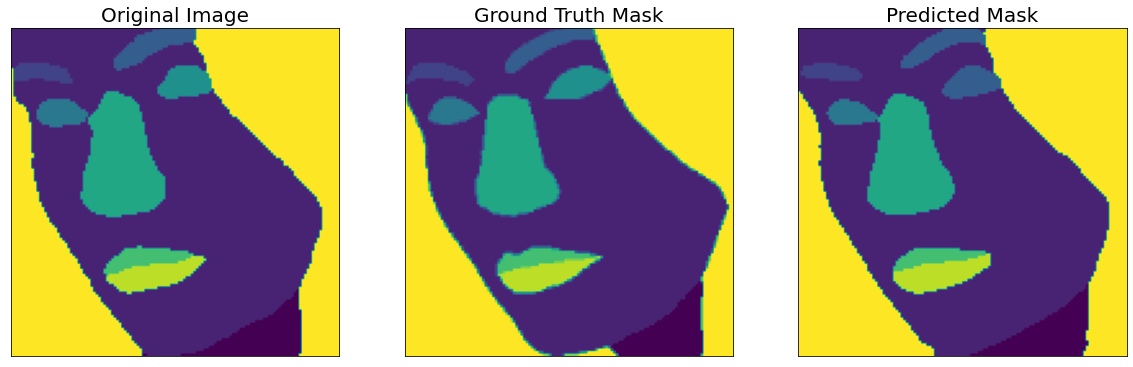

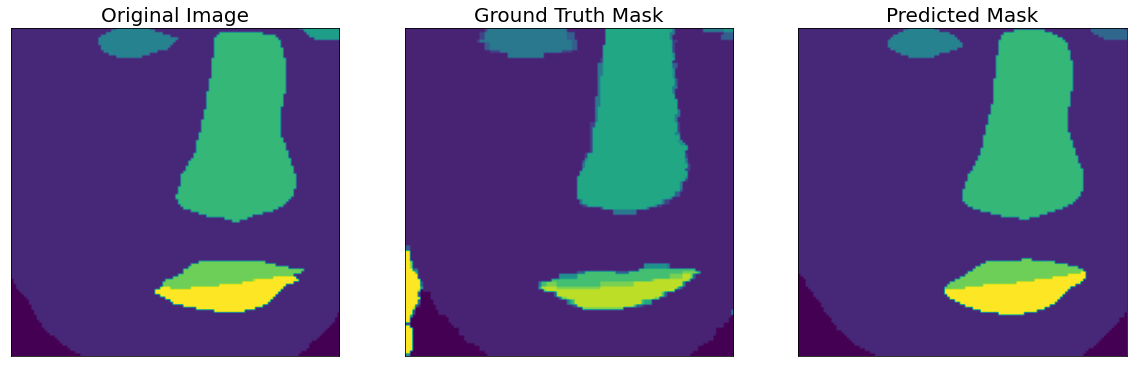

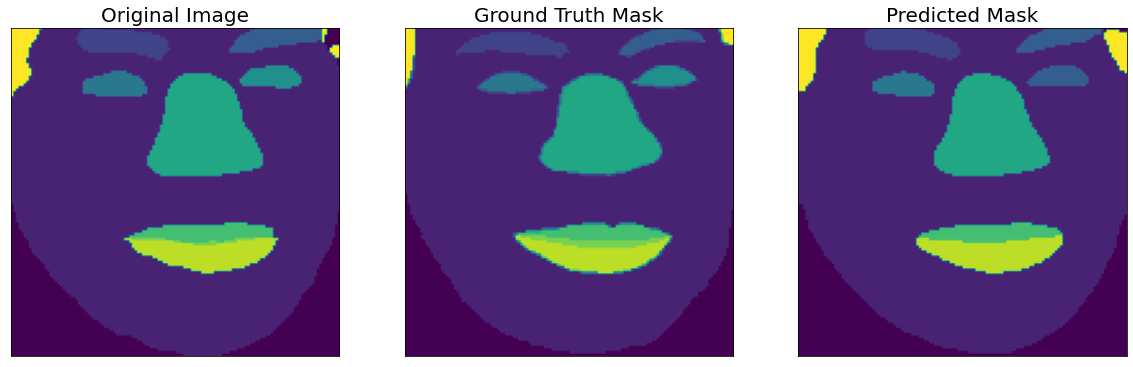

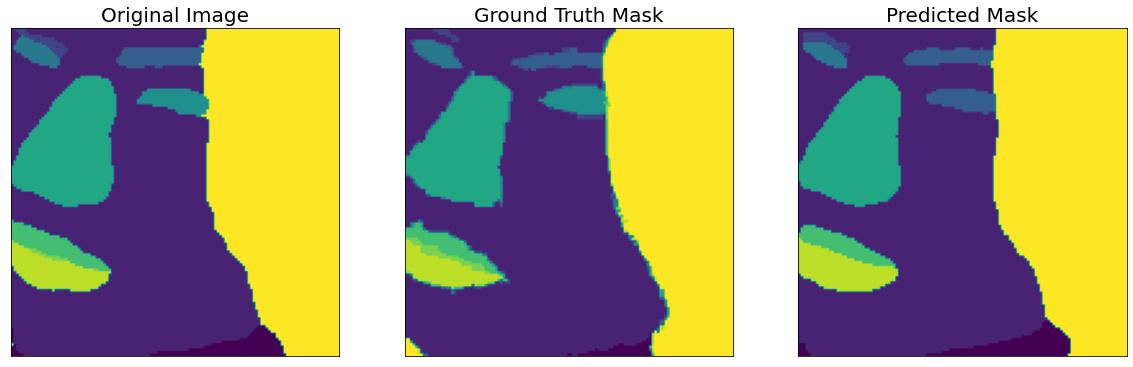

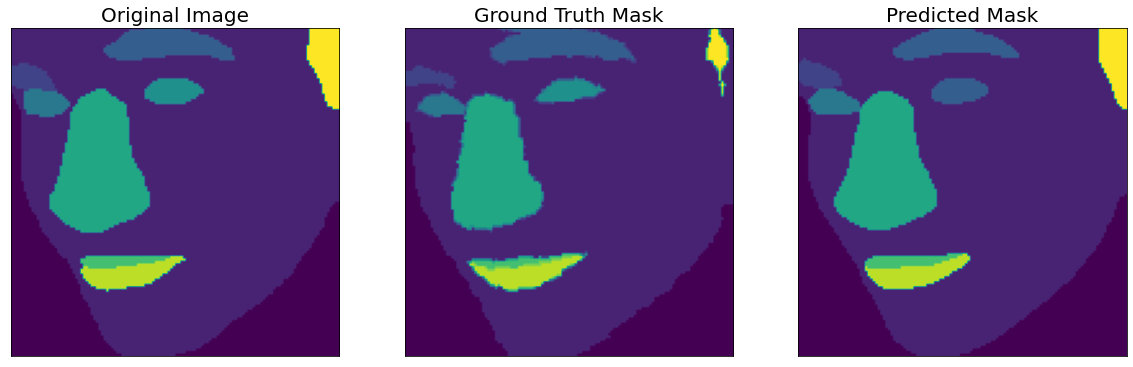

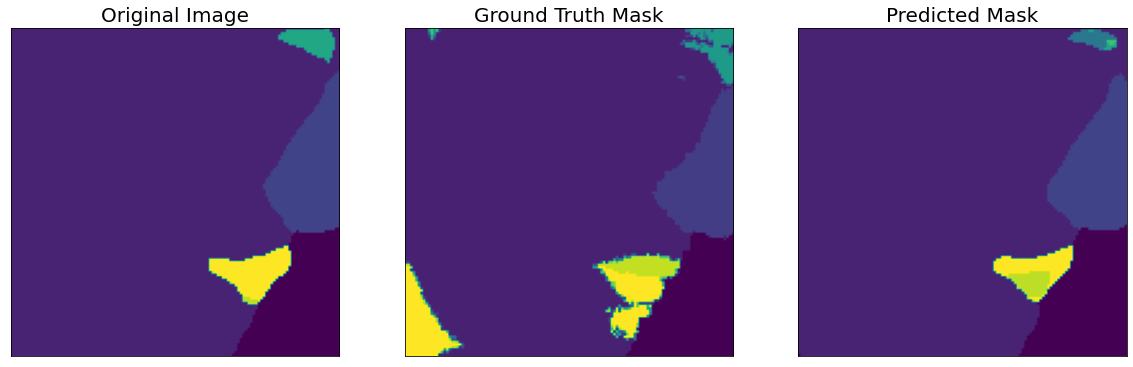

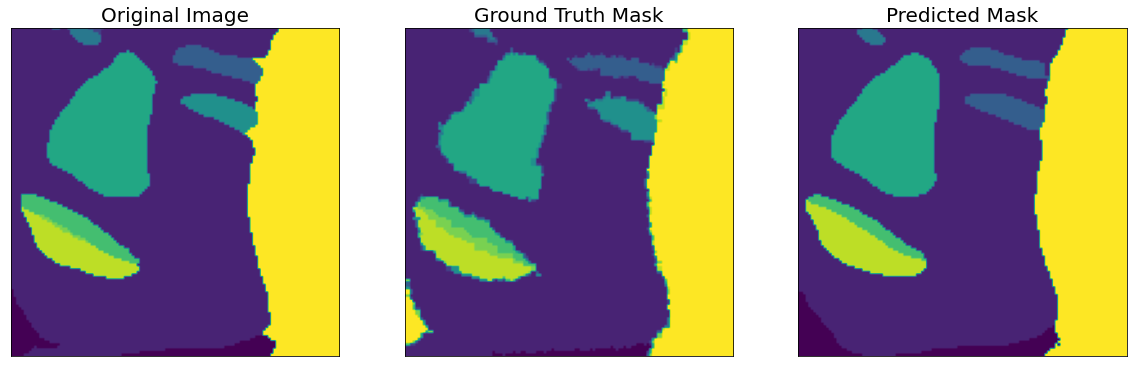

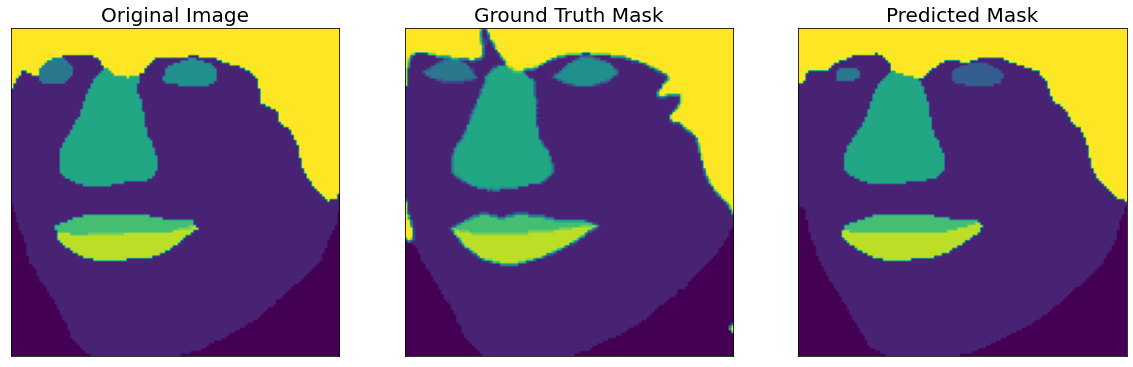

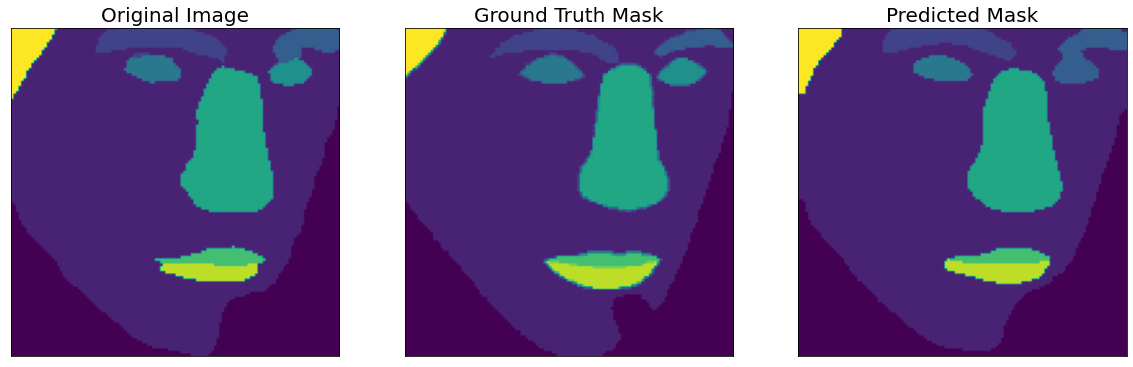

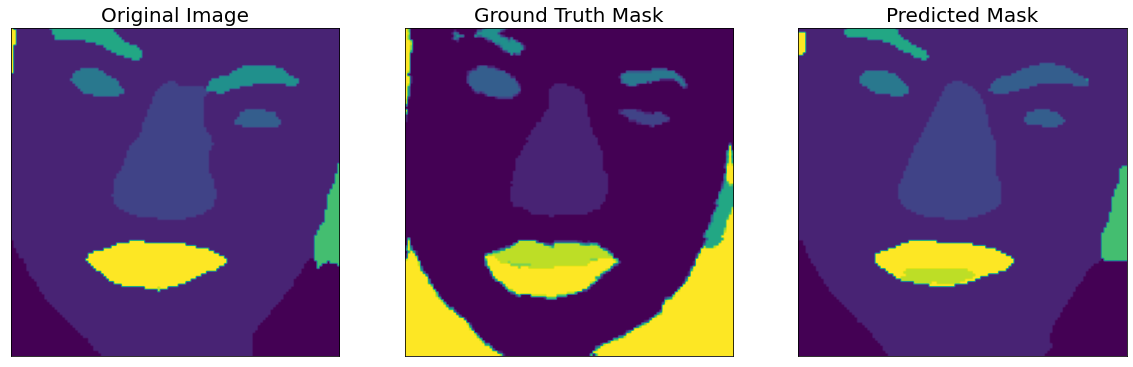

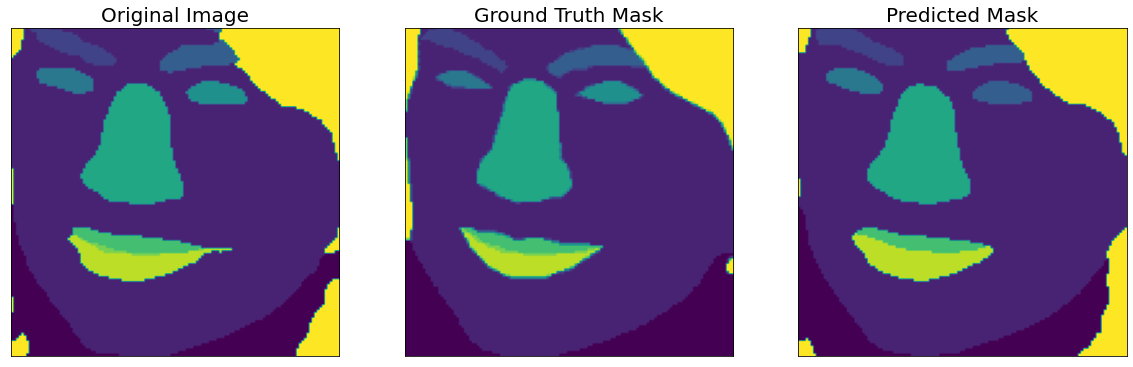

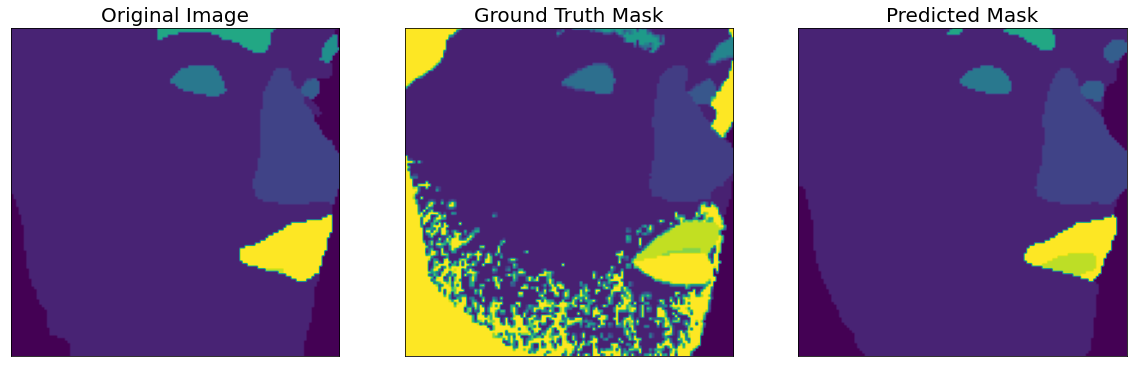

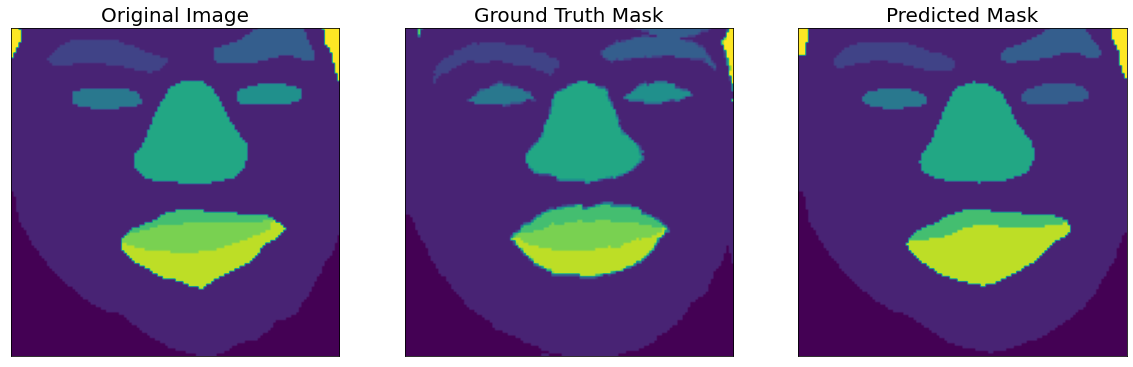

Dataset MIoU =  0.38318799568805845
Dataset F1 =  [0.682325   0.9229296  0.72167885 0.435602   0.5985461  0.40000105
 0.6896683  0.57075316 0.40000105 0.6053836  0.6410109  0.40000105]
Dataset F1 av =  0.5889917


In [ ]:
model = torch.load("/content/drive/MyDrive/FRESH/label_adapter.pth", map_location=DEVICE)

view_label_predictions(model,val_ds2, num_classes)